In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from src import create_simple_plot_with_tables, BS468ReferenceResponse, plot_bs468_response_with_tables, weighting_filter_response
from src import verify_exact_values, plot_accurate_response, generate_calibration_table, export_for_filter_design, plot_fir_response_with_tolerance
from src import analyze_residuals, simple_residuals_analysis, short_residuals_analysis
from src import print_model_results
from src import plot_predict, plot_predict_detal
from src import BS468ReferenceResponse_fir, design_bs468_fir_filter, create_low_pass_filter

# Введение

В данном исследовании рассматривается задача проектирования цифрового псофометрического фильтра с использованием метода наименьших квадратов (МНК) в комбинации с методами машинного обучения. Актуальность работы обусловлена необходимостью точного моделирования субъективного восприятия акустических помех в системах радиовещания и телефонии.

**Назначение и принцип работы псофометрического фильтра**

Псофометрический фильтр — это специализированный частотный фильтр, основное назначение которого заключается в имитации двух ключевых аспектов:<br>
- **Частотной чувствительности человеческого уха** — ухо человека имеет неравномерную чувствительность к разным частотам, с максимумом в области 1-4 кГц.
- **Частотных характеристик типовых каналов передачи** — как радиовещательных, так и телефонных, которые имеют ограниченную полосу пропускания.

Фильтр осуществляет "взвешивание" спектральных компонент шума в соответствии с их субъективной раздражительностью, преобразуя физическую мощность шума в **псофометрическую мощность**, измеряемую в пиковаттах псофометрических (pWp) или децибелах псофометрических (дБпс).

**Важность для радиовещательных передатчиков**

При измерении нелинейных искажений (интермодуляции) в радиовещательных передатчиках образуются комбинационные продукты на различных частотах. Псофометрический фильтр выполняет критически важную функцию:<br>

- **Усиление значимости** продуктов искажения в области 800-1500 Гц, где человеческое ухо наиболее чувствительно.
- **Ослабление влияния** продуктов искажения ниже 300 Гц (плохо слышимых) и выше 3000 Гц (ограниченно пропускаемых трактом вещания).

Таким образом, применение псофометрической характеристики позволяет получить **единый интегральный показатель качества**, который:<br>
- Хорошо коррелирует с субъективной оценкой помех при прослушивании
- Обеспечивает объективное отражение помехи, которую фактически услышит слушатель
- Позволяет стандартизировать измерения в технической документации

**Выбор стандарта и методология**

В данной работе проектирование фильтра осуществляется в соответствии с рекомендацией **BS.468-4**, которая широко применяется в радиовещательном оборудовании. Ключевыми параметрами проектирования являются:
- **Амплитудно-частотная характеристика (АЧХ)** — определяет коэффициент передачи фильтра на разных частотах
- **Фазо-частотная характеристика (ФЧХ)** — определяет фазовый сдвиг, вносимый фильтром


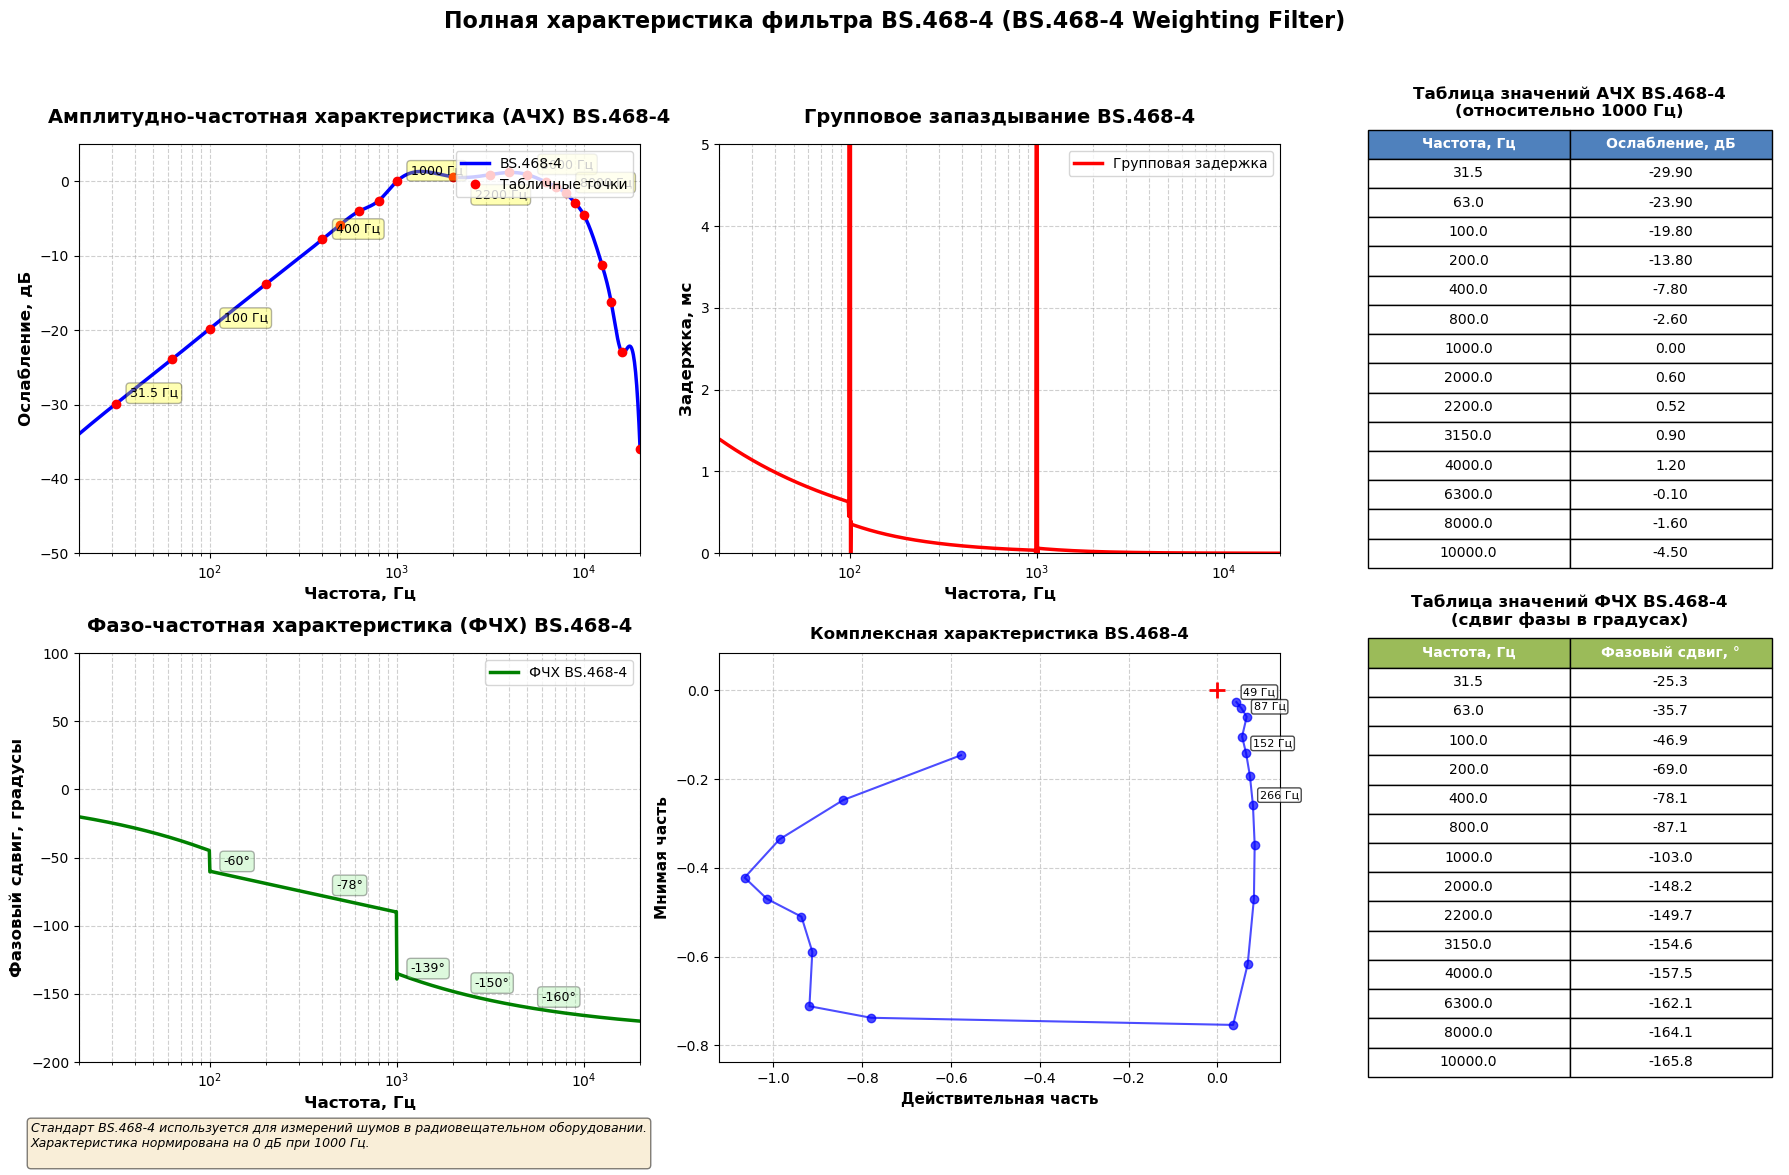

In [312]:
plot_bs468_response_with_tables()

Для цифровой реализации выбрана архитектура **КИХ-фильтра (фильтра с конечной импульсной характеристикой)**, что обеспечивает:

- Линейность фазовой характеристики
- Устойчивость (отсутствие проблемы неустойчивости)
- Точное соответствие заданным параметрам

## **Суть КИХ-фильтра**<br>

КИХ-фильтр — это линейный цифровой фильтр, выходной сигнал которого зависит только от текущего и предыдущих значений входного сигнала. Его главная особенность — импульсная характеристика имеет конечную длительность (отсюда и название).

**Основная формула (временная область, свертка)**<br>

Выходной сигнал y[n] КИХ-фильтра — это дискретная свертка входного сигнала x[n] с его коэффициентами (импульсной характеристикой) h[k].<br>

Формула КИХ-фильтра порядка N:<br> 
$$
y[n] = \sum_{k=0}^{N} h[k] \cdot x[n-k]
$$
где:
- $y[n]$ - выходной сигнал в момент времени n
- $h[k]$ - **коэффициенты фильтра** (импульсная характеристика). Всего N+1 коэффициент (h[0], h[1], ..., h[N]).
- $x[n]$ - входной сигнал в момент времени n
- $N$ - **порядок фильтра**. Чем выше порядок, тем сложнее форма АЧХ и выше вычислительная нагрузка.
- $k$ - индекс коэффициента.

Простыми словами: Каждый текущий выход y[n] — это взвешенная сумма текущего входного значения x[n] и N предыдущих входных значений x[n-1], x[n-2], ..., x[n-N]. Весами служат коэффициенты h[k].

## **Связь КИХ-фильтров и линейной регрессии**

Обе модели являются **линейными комбинаторами** и линейно зависят от своих параметров:
- **КИХ-фильтр**: `h[k]` (коэффициенты фильтра)
- **Линейная регрессия**: `βⱼ` (коэффициенты регрессии)

**Формула КИХ-фильтра** представляет **взвешенную сумму запаздывающих входов**:
$$
y_t = h_0 x_t + h_1 x_{t-1} + \dots + h_N x_{t-N}
$$

**Формула линейной регрессии** представляет **взвешенную сумму признаков**:
$$
\hat{y}_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Это структурное сходство позволяет использовать алгоритмы машинного обучения 
(в частности, линейную регрессию) для вычисления коэффициентов КИХ-фильтра.

## **Методология проектирования фильтра**

В данном исследовании для проектирования цифрового псофометрического фильтра применяется **комбинированный подход**, объединяющий:

### **1. Метод наименьших квадратов (МНК)** 
Как математическую основу для минимизации ошибки аппроксимации целевой характеристики BS.468-4.

### **2. Ridge-регрессию**
Как метод машинного обучения, реализующий МНК с L2-регуляризацией, что позволяет:
- Получать устойчивые решения (уменьшение переобучения)
- Контролировать энергию коэффициентов фильтра
- Улучшать обобщающую способность модели

### **3. Архитектуру КИХ-фильтра**
Коэффициенты Ridge-модели напрямую интерпретируются как **коэффициенты КИХ-фильтра**:

$$
h[n] = \beta_n, \quad n = 0, 1, \dots, N-1
$$

где:
- $h[n]$ — импульсная характеристика фильтра
- $\beta_n$ — коэффициенты, полученные Ridge-регрессией  
- $N$ — порядок фильтра (количество коэффициентов)

Для заданного набора частот $\{f_k\}$ и соответствующих целевых значений АЧХ и ФЧХ $H_{\text{target}}(f_k)$, требуется найти коэффициенты КИХ-фильтра $h[n]$, минимизирующие функционал (МНК с L2-регуляризацией):

$$
J(\mathbf{h}) = \sum_{k=1}^{K} \left| H(\mathbf{h}, f_k) - H_{\text{target}}(f_k) \right|^2 + \alpha \sum_{n=0}^{N-1} |h[n]|^2
$$

где:
- $H(\mathbf{h}, f_k)$ — частотная характеристика фильтра с коэффициентами $h[n]$ на частоте $f_k$
- $H_{\text{target}}(f_k)$ — целевая частотная характеристика
- $\alpha$ — параметр регуляризации Ridge-регрессии
- Первое слагаемое — ошибка аппроксимации (метод наименьших квадратов)
- Второе слагаемое — штраф за большие коэффициенты (L2-регуляризация)

## **Алгоритм проектирования**

1. **Формирование обучающей выборки**:
   - Входные данные: гармонические сигналы различных частот
   - Целевые значения: сигналы, искаженные согласно АЧХ и ФЧХ BS.468-4

2. **Обучение Ridge-модели**:
   ```python
   from sklearn.linear_model import Ridge
   
   model = Ridge(alpha=0.1, fit_intercept=False)
   model.fit(X_train, y_train)

3. **Извлечение коэффициентов фильтра**:
   ```python
   fir_coefficients = model.coef_  # Импульсная характеристика фильтра

4. **Валидация результатов**:
   - Сравнение АЧХ/ФЧХ полученного фильтра с эталоном
   - Вычисление метрик качества (R², MSE, MAE)

## **Преимущества подхода**
- **Автоматизация**: Процесс проектирования полностью автоматизирован
- **Точность**: Минимизация среднеквадратичной ошибки гарантирует близость к эталону
- **Устойчивость**: Регуляризация предотвращает переобучение
- **Интерпретируемость**: Коэффициенты модели — это и есть коэффициенты фильтра
- **Гибкость**: Легко адаптируется к другим стандартам фильтров   

# Подготовка данных

**АЧХ и ФЧХ фильтра BS.468-4**<br>

При проектировании псофометрического фильтра в качестве целевых характеристик используются значения амплитудно-частотной (АЧХ) и фазо-частотной (ФЧХ) характеристик, регламентированные рекомендацией BS.468-4. Именно эти характеристики определяют, каким образом фильтр должен преобразовывать входной сигнал: ослаблять или усиливать его спектральные составляющие и сдвигать их по фазе в зависимости от частоты.

На рисунке ниже представлены:

- **АЧХ фильтра** в логарифмическом масштабе (дБ) и в линейных единицах (коэффициент передачи);
- **ФЧХ фильтра** (фазовый сдвиг в градусах);
- **Комплексная плоскость**, иллюстрирующая изменение коэффициента передачи (модуль) и фазового сдвига (аргумент) комплексной частотной характеристики фильтра на различных частотах. Каждая точка на комплексной плоскости соответствует отклику фильтра на определённой частоте, что позволяет наглядно оценить совместное влияние АЧХ и ФЧХ.

Далее приведена калибровочная таблица значений АЧХ (в децибелах и относительных единицах) и ФЧХ (в градусах) фильтра BS.468-4 для набора тестовых частот, охватывающих весь рабочий диапазон. Данные значения используются в качестве эталона при формировании обучающей выборки и последующей оценке качества аппроксимации.

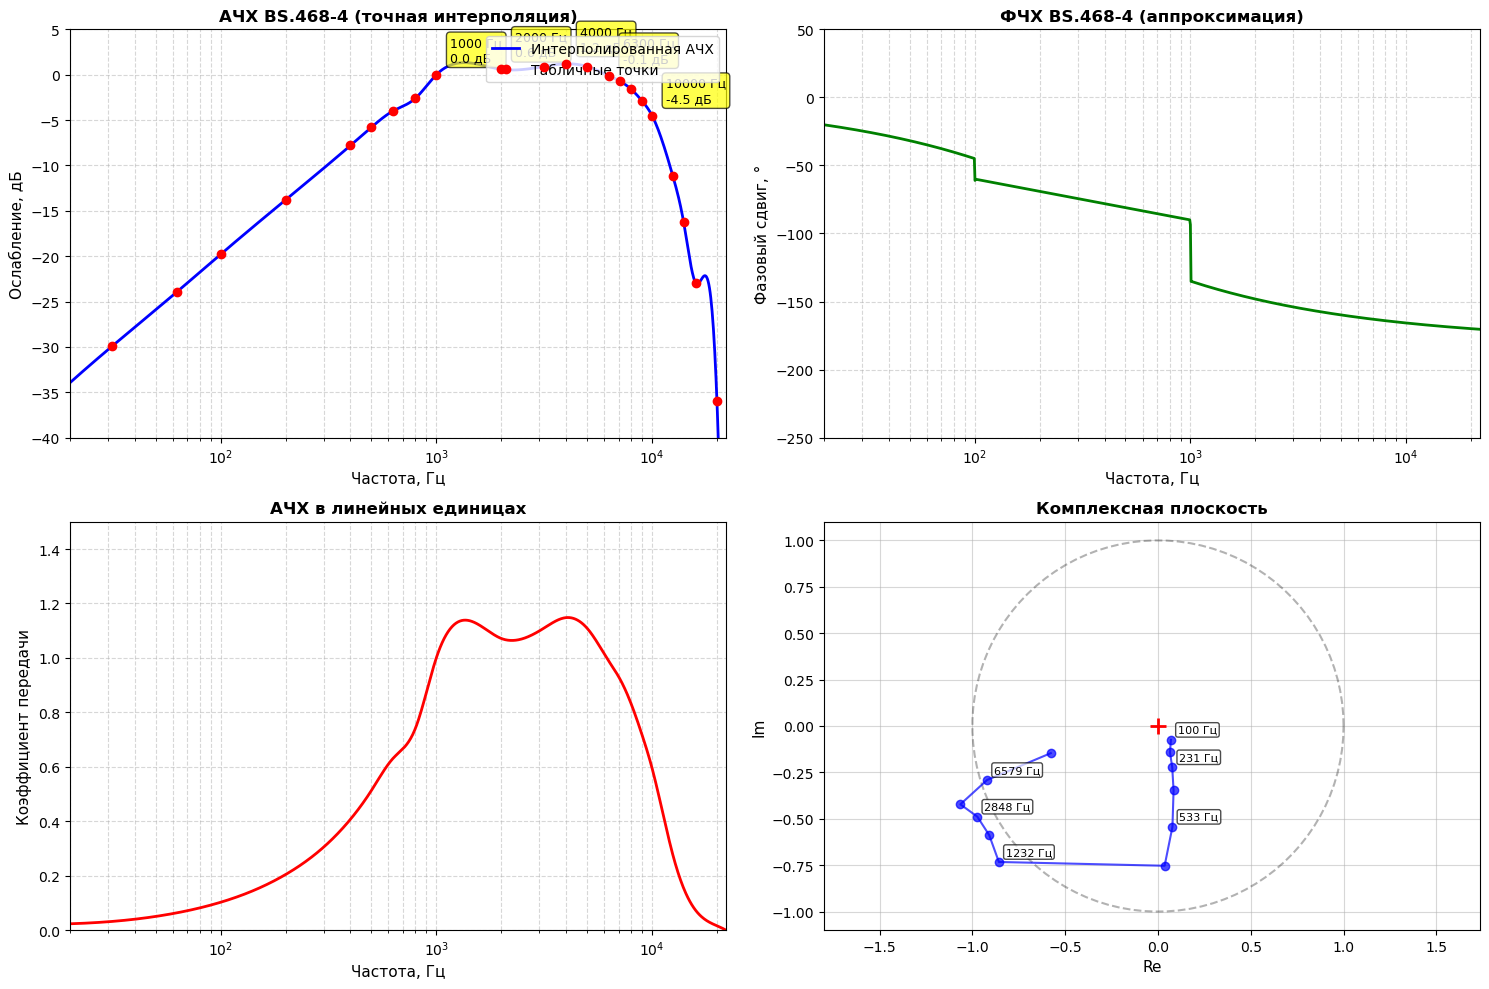


КАЛИБРОВОЧНАЯ ТАБЛИЦА BS.468-4
Частота  АЧХ (дБ)     Коэф. передачи     ФЧХ (°)      В таблице 
----------------------------------------------------------------------------------------------------
31.5     -29.900      0.031989           -25.3        Да         
63.0     -23.900      0.063826           -35.7        Да         
100.0    -19.800      0.102329           -46.9        Да         
200.0    -13.800      0.204174           -69.0        Да         
400.0    -7.800       0.407380           -78.1        Да         
500.0    -5.800       0.512861           -81.0        Да         
630.0    -4.000       0.630957           -84.0        Да         
800.0    -2.600       0.741310           -87.1        Да         
1000.0   0.000        1.000000           -103.0       Да         ← опорная
1500.0   1.230        1.130596           -143.3                  
2000.0   0.600        1.071519           -148.2       Да         ← ключевая
2500.0   0.566        1.070050           -151.5          

In [2]:
# Опорная частота: 1000 Гц = 0 дБ
# Тип интерполяции: Кубические сплайны в логарифмической шкале
    
# Точная проверка
#bs468 = verify_exact_values()
    
# Графики
bs468 = plot_accurate_response()
    
# Калибровочная таблица
bs468 = generate_calibration_table()
    
# Экспорт для проектирования
#bs468, freqs, mag_db, phase_deg, complex_resp = export_for_filter_design()    

## Создание датасета

Для обучения модели, аппроксимирующей поведение псофометрического фильтра, необходимо сформировать обучающую выборку, имитирующую его реакцию на различные входные сигналы. Процесс формирования датасета состоит из нескольких этапов.

**1. Генерация входных сигналов**

В качестве входных сигналов используются гармонические колебания (синусоиды) вида:



$$x(t) = \sin(2\pi f t + \varphi_0), \text{ где }$$
$$
\begin{aligned}
& f \text{ — частота сигнала, варьируется в диапазоне от 30 до 20000 Гц;} \\
& \varphi_0 \text{ — начальная фаза (для упрощения принимается равной нулю).}
\end{aligned}
$$
Для каждой частоты генерируется непрерывный сигнал, который затем дискретизируется с частотой дискретизации $f_s = 48$ кГц, что соответствует стандартной частоте дискретизации профессионального аудиооборудования. В результате получается дискретная последовательность отсчётов:<br>
$$
\begin{aligned}
& x[n] = \sin\left( 2\pi \frac{f}{f_s} n + \varphi_0 \right), \quad n = 0, 1, 2, \dots
\end{aligned}
$$

**2. Формирование признакового пространства**

Каждый пример в датасете представляет собой фрагмент входного сигнала фиксированной длины — 128 последовательных отсчётов. Эти отсчёты образуют вектор признаков размерности 128, соответствующий одной строке обучающей выборки.

Для получения достаточного количества примеров используется скользящее окно: первый набор признаков формируется из отсчётов $x[0] \ldots x[127]$, второй — $x[1] \ldots x[128]$, третий — $x[2] \ldots x[129]$ и так далее. Шаг смещения составляет один отсчёт.

Количество формируемых наборов признаков для каждой частоты определяется переменной min_num_string_features. При этом должно выполняться условие: временной интервал, покрываемый всеми наборами признаков для данной частоты, должен составлять не менее одного полного периода входного сигнала. Это гарантирует, что модель обучается на различных фазах колебания.

**3. Формирование целевой переменной**

Для каждого входного набора признаков (вектора $x[n] \ldots x[n+127]$) вычисляется соответствующее целевое значение — отсчёт выходного сигнала идеального фильтра BS.468-4 в момент времени, соответствующий последнему отсчёту окна.

Выходной сигнал фильтра для гармонического входного сигнала частоты $f$ определяется двумя параметрами:<br>
**Коэффициент передачи** $k(f)$ — модуль частотной характеристики фильтра на частоте $f$ (АЧХ в линейных единицах);<br>
**Фазовый сдвиг** $\phi(f)$ — аргумент частотной характеристики фильтра на частоте $f$ (ФЧХ в радианах).

Тогда выходной дискретный сигнал фильтра имеет вид:
$$y[n] = k(f) \cdot \sin\left( 2\pi \frac{f}{f_s} n + \varphi_0 + \phi(f) \right)$$
Целевой переменной для набора признаков, начинающегося с отсчёта $n$, является значение $y[n+127]$ — выход фильтра на момент последнего отсчёта текущего окна.

**4. Структура итогового датасета**

В результате описанной процедуры формируются две выборки:

$X_{\text{train}}$ — матрица признаков размера $M \times 128$, где каждая строка содержит 128 последовательных отсчётов входного сигнала;<br>
$y_{\text{train}}$ — вектор целевых значений длины $M$, содержащий соответствующие отсчёты выходного сигнала фильтра.

Аналогичным образом формируются тестовая выборка ($X_{\text{test}}$, $y_{\text{test}}$), для которой используются частоты, не входящие в обучающий набор, что позволяет объективно оценить обобщающую способность модели.

Такой подход к формированию датасета полностью соответствует задаче аппроксимации КИХ-фильтра: каждый пример связывает фрагмент входной последовательности с одним выходным отсчётом, что позволяет модели восстановить импульсную характеристику фильтра методом линейной регрессии.

In [3]:
def get_descret_for_freq(freq_descr, freq, fi, num_features, min_num_string_features, k_f, fi_f):
    """
    Вычисление синусоидальных признаков и меток.
    
    Args:
        k_values: массив временных отсчётов
        freq: частота сигнала (Гц)
        freq_descr: частота дискретизации (Гц)
        fi: начальная фаза для X (радианы)
        num_features: количество признаков в одном векторе
        k_f: коэффициент амплитуды для y
        fi_f: дополнительный фазовый сдвиг для y (радианы)
        values_X: одномерный массив входного сигнала

    Returns:
        arr_features: 2-мерный массив значений входного сигнала - датасет признаков
        values_y: вычисленные значения сигнала - массив с ответами (целевая переменная)
    """    
    # Вычисляем кол-во строк параметров
    min_num_samples = min_num_string_features + num_features - 1 
    if min_num_samples > np.ceil(freq_descr / freq):
        num_samples = min_num_samples + num_features
    else:           
        num_samples = np.ceil(freq_descr / freq) + num_features      
    
    # Создаем массив индексов k
    k_values = np.arange(num_samples)

    # Угловая частота в дискретной области
    omega = 2 * np.pi * freq / freq_descr
    
    # Вычисление значений для X (все точки)
    values_X = np.sin(omega * k_values + fi)
    
    # Вычисление значений для y (только последние точки каждого feature-вектора)
    feature_end_indices = k_values[num_features - 1::1]
    phase_y = fi + fi_f
    values_y = k_f * np.sin(omega * feature_end_indices + phase_y)

    # Преобразуем в 2D массив
    arr_features = np.vstack([values_X[i:i+num_features] for i in range(len(values_X)-(num_features-1))])
    
    return arr_features, values_y

def combine_frequencies_dynamic(freq_descr, freq_list, fi_list, num_features, min_sample_num, k_f_list, fi_f_list):
    """
    Динамическое добавление строк в общий массив
    """
    # Создаем пустой массив с нужным количеством столбцов
    result_X = np.empty((0, num_features))
    result_y = np.array([])
    
    for freq, fi, k_f, fi_f, s_num in zip(freq_list, fi_list, k_f_list, fi_f_list, min_sample_num):    
        arr_X, arr_y = get_descret_for_freq(freq_descr, freq, fi, num_features, s_num, k_f, fi_f)
        # Добавляем строки текущей частоты в общий массив
        result_X = np.vstack((result_X, arr_X))
        result_y = np.hstack((result_y, arr_y))
    
    column_names = [f'x{i+1}' for i in range(result_X.shape[1])]
    df_X = pd.DataFrame(result_X, columns=column_names)
    df_y = pd.DataFrame({'target': result_y})

    #return result_X, result_y
    return df_X, df_y

# Визуализация
def plot_input_output_signal(samples_num, df_X, df_y, in_column_name='x128',out_column_name='target'):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    x_values = np.arange(samples_num)
    y1 = df_X[in_column_name].iloc[:samples_num].values
    y2 = df_y[out_column_name].iloc[:samples_num].values

    # Входной сигнал
    ax1.plot(x_values, y1, 'b-', linewidth=1, alpha=0.7, label='Вх.сигнал')
    ax1.scatter(x_values, y1, s=20, c='blue', alpha=0.5, marker='o')
    ax1.set_ylabel('Амплитуда', fontsize=12, fontweight='bold')
    ax1.set_title('Входной сигнал', fontsize=14, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
    ax1.fill_between(x_values, y1, 0, alpha=0.2, color='blue')
    ax1.set_ylim(-1.1, 1.1)
    ax1.legend()

    # Выходной сигнал
    ax2.plot(x_values, y2, 'r-', linewidth=1, alpha=0.7, label='Вых.сигнал')
    ax2.scatter(x_values, y2, s=20, c='red', alpha=0.5, marker='s')
    ax2.set_xlabel('Порядковый номер отсчета', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Амплитуда', fontsize=12, fontweight='bold')
    ax2.set_title('Выходной сигнал', fontsize=14, fontweight='bold')
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
    ax2.fill_between(x_values, y2, 0, alpha=0.2, color='red')
    ax2.set_ylim(-1.1, 1.1)
    ax2.legend()

    plt.tight_layout()
    plt.show()    


**Проверка работы основных функций для формирования выборок**<br>
Корректность работы функций, отвечающих за формирование обучающих и тестовых выборок, является необходимым условием достоверности дальнейшего эксперимента. В связи с этим была проведена верификация трех ключевых функций:<br>
- get_magnitude_linear() — возвращает коэффициент передачи фильтра $k(f)$ на заданной частоте в линейных единицах (в соответствии с АЧХ BS.468-4);
- get_phase_rad() — возвращает фазовый сдвиг $\phi(f)$, вносимый фильтром на заданной частоте, в радианах (в соответствии с ФЧХ BS.468-4);
- combine_frequencies_dynamic() — формирует матрицу признаков $X$ и вектор целевых значений $y$ на основе входных синусоидальных сигналов, их частот, а также полученных коэффициентов передачи и фазовых сдвигов.

Для проверки корректности совместной работы перечисленных функций был выполнен следующий тест.

**Условия теста:**<br>
- Частота входного сигнала: $f = 190$ Гц;
- Частота дискретизации: $f_s = 48$ кГц;
- Начальная фаза: $\varphi_0 = 0$;

Для выбранной частоты с помощью функций get_magnitude_linear(190) и get_phase_rad(190) были получены эталонные значения:
- Коэффициент передачи: $k \approx 0.2$;
- Фазовый сдвиг: $\phi \approx -70^\circ$ ($-1.22$ рад).

Данные значения соответствуют калибровочной таблице BS.468-4, согласно которой в области частот 150–200 Гц фильтр вносит существенное ослабление (около —14 дБ, что соответствует $k \approx 0.2$) и фазовую задержку порядка —70°.

На рисунке ниже представлен совмещённый график входного и выходного сигналов, сформированных функцией combine_frequencies_dynamic().

**Наблюдаемые эффекты:**

1. **Ослабление амплитуды** — амплитуда выходного сигнала (оранжевая кривая) составляет приблизительно 0.2 от амплитуды входного сигнала (синяя кривая), что визуально подтверждает корректность работы функции get_magnitude_linear().
2. **Фазовый сдвиг** — выходной сигнал отстаёт от входного; величина отставания, измеренная по временной оси, составляет $\Delta t \approx 1.04$ мс (50 отсчетов с частотой дискретизации 48 кГц), что при периоде входного сигнала $T = 1/190 \approx 5.26$ мс соответствует фазовому сдвигу:
$$
\phi = -360^\circ \cdot \frac{\Delta t}{T} = -360^\circ \cdot \frac{1.04}{5.26} \approx -71.1^\circ
$$ 

Полученное значение с высокой точностью совпадает с эталонным $\phi = -70^\circ$, что подтверждает корректность работы функции get_phase_rad().

Сохранение формы сигнала — выходной сигнал остаётся строго синусоидальным, без нелинейных искажений, что соответствует линейности моделируемого фильтра.

Вывод:
Все три проверяемые функции работают корректно и согласованно. Функции get_magnitude_linear() и get_phase_rad() возвращают значения, в точности соответствующие табличным данным BS.468-4. Функция combine_frequencies_dynamic() правильно формирует признаковое пространство и целевые переменные, сохраняя заданные АЧХ и ФЧХ-характеристики фильтра. Это позволяет использовать сгенерированные данные для последующего обучения модели машинного обучения без риска внесения дополнительных методических ошибок на этапе подготовки данных.

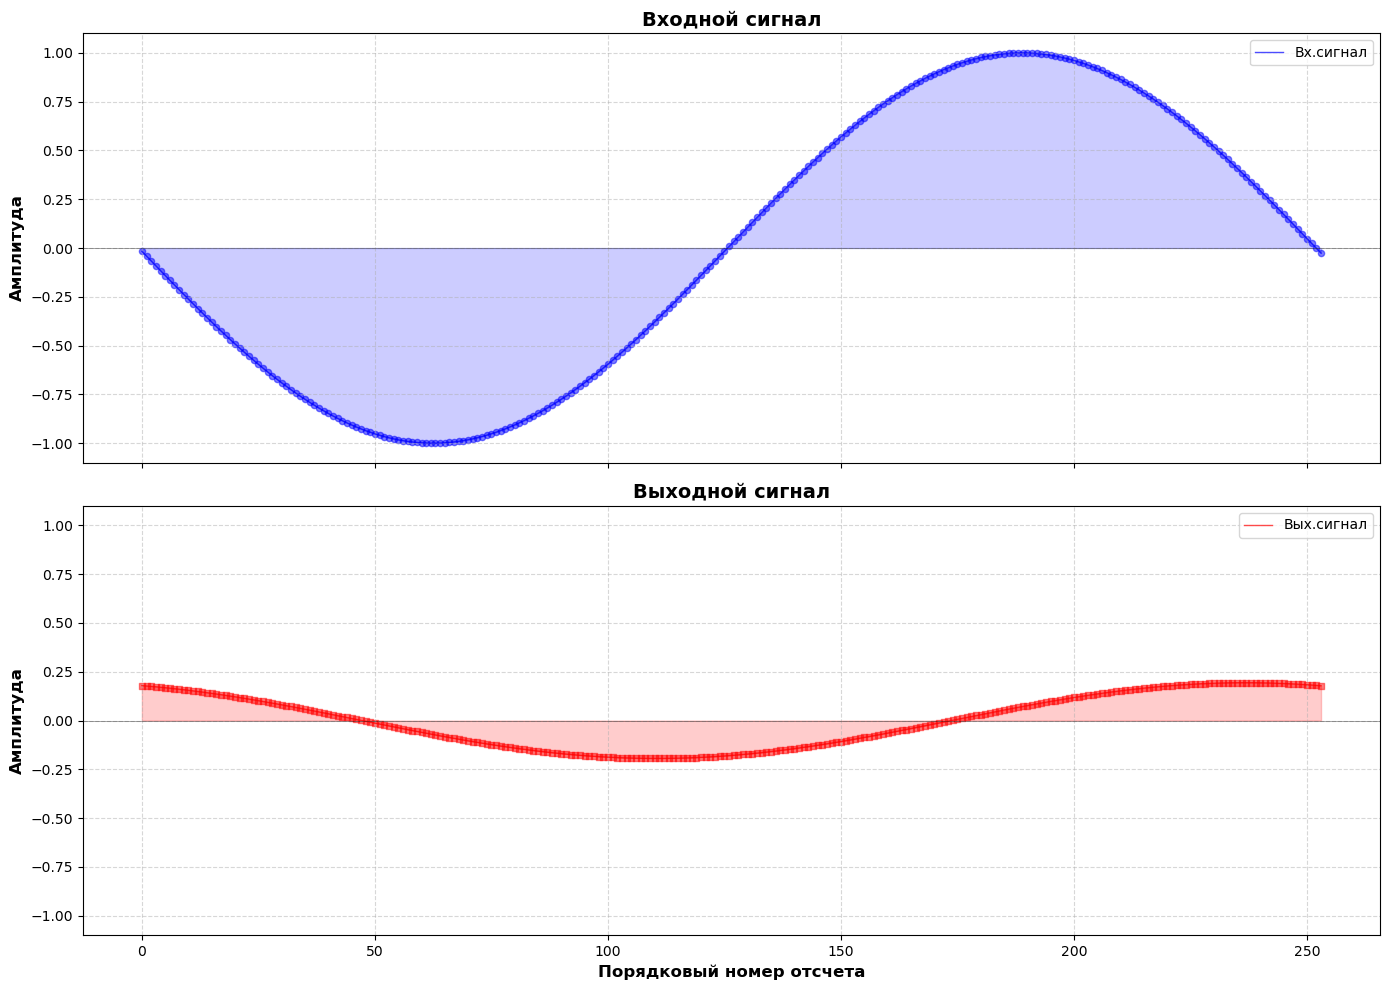

In [ ]:
# Проверка
bs468_expl = BS468ReferenceResponse()
freqs_expl = [190]
fi_expl = [0]
mag_array_expl = bs468_expl.get_magnitude_linear(freqs_expl) # значение амплитуды в соответствии с АЧХ фильтра 
phase_array_expl = bs468_expl.get_phase_rad(freqs_expl)      # значение фазы в соответствии с АЧХ фильтра
df_X_expl, df_y_expl = combine_frequencies_dynamic(48000, freqs_expl, fi_expl, 128, [40], mag_array_expl, phase_array_expl) 

plot_input_output_signal(254, df_X_expl, df_y_expl, in_column_name='x128',out_column_name='target')

**Формирование обучающей и тестовой выборок**<br>
После верификации базовых функций перейдём к непосредственному формированию обучающей и тестовой выборок, которые будут использованы для тренировки и оценки модели машинного обучения.

**Обучающая выборка**

Для обеспечения достаточной репрезентативности обучающей выборки необходимо, чтобы она покрывала весь рабочий диапазон частот псофометрического фильтра (от единиц герц до 20 кГц) с достаточной плотностью, а также включала различные начальные фазы входных сигналов.

В связи с этим сетка частот для генерации обучающих примеров формируется следующим образом:

- **Диапазон 1–100 Гц**: шаг **1 Гц** (100 частотных точек);
- **Диапазон 100–20000 Гц**: шаг **3 Гц** (≈ 6637 частотных точек).

Общее количество частот в обучающей сетке составляет приблизительно 6737 точек, что обеспечивает высокое разрешение по частоте и позволяет модели точно аппроксимировать как крутые спады АЧХ в низкочастотной области, так и плавные изменения в рабочей полосе фильтра.

Для каждой частоты генерируется три варианта входного сигнала, отличающихся начальной фазой $\varphi_0$:<br>
$0^\circ$ (0 рад)<br>
$30^\circ$ ($\pi/6$ рад)<br>
$60^\circ$ ($\pi/3$ рад)<br>

Введение фазового сдвига во входном сигнале позволяет:

- Увеличить разнообразие обучающей выборки — модель обучается на сигналах, проходящих через различные участки синусоиды, что повышает её обобщающую способность;
- Исключить "привязку" к фазе — фильтр BS.468-4 является линейной системой с постоянными параметрами, его реакция не зависит от фазы входного сигнала; включение различных фаз в обучение помогает модели абстрагироваться от начальной фазы и лучше выделить инвариантные характеристики фильтра;
- Снизить риск переобучения — увеличение объёма и разнообразия данных за счёт фазовых сдвигов без необходимости расширения частотной сетки.

Тестовая выборка

Для объективной оценки качества обученной модели тестовая выборка формируется независимо от обучающей. В качестве тестовых частот используются табличные значения из рекомендации BS.468-4:

$$f_{\text{test}} \in \{31.5,\ 63,\ 100,\ 200,\ 400,\ 500,\ 630,\ 800,\ 1000,\ 2000,\ 3150,\ 4000,\ 5000,\ 6300,\ 7100,\ 8000,\ 9000,\ 10000,\ 12500,\ 14000,\ 16000,\ 20000\} \ \text{Гц}$$

Данные частоты являются реперными точками стандарта и в точности соответствуют значениям, для которых в рекомендации приведены эталонные АЧХ и ФЧХ. Это позволяет:

- провести **валидацию модели** непосредственно по отношению к официальным спецификациям;
- оценить **интерполяционные способности** модели — насколько точно она предсказывает поведение фильтра на частотах, отсутствовавших в обучении.

Для тестовой выборки начальная фаза всех входных сигналов принимается равной $0^\circ$, что обеспечивает единообразие условий оценки и упрощает интерпретацию результатов.

**Итоговые параметры выборок**

| Параметр | Обучающая выборка | Тестовая выборка |
|----------|-------------------|------------------|
| Частотный диапазон | 1–20000 Гц | 31.5–20000 Гц |
| Шаг сетки | 1 Гц (1–100 Гц), 3 Гц (100–20000 Гц) | — (фиксированные частоты) |
| Количество частот | ≈ 6737 | 22 |
| Начальные фазы | $0^\circ$, $30^\circ$, $60^\circ$ | $0^\circ$ |
| Признаки на частоту | $N_{\text{samples}}$ (определяется длиной сигнала) | $N_{\text{samples}}$ |

После генерации все сформированные признаки и целевые значения будут находиться в массивах $X_{\text{train}}$, $y_{\text{train}}$ и $X_{\text{test}}$, $y_{\text{test}}$, которые затем используются для обучения и оценки модели Ridge-регрессии.

**Примечание**: **ВНИМАНИЕ! Формирование обучающей выборки занимает много времени** (несколько часов на мощном ПК).<br>
Для получения обучающей выборки нужно раскомментировать соответствующий код ниже.

In [ ]:
bs468 = BS468ReferenceResponse()
##freqs_train += [31,63,100,200,400,500,630,800,1000,2000,3150,4000,5000,6300,7100,8000,9000,10000,12500,14000,16000,20000]

freqs_train_00_1 = [1 * (i + 1) for i in range(100)]
freqs_train_00_2 = [3 * (i + 33) for i in range(6870)]
freqs_train_30_1 = [1 * (i + 1) for i in range(100)]
freqs_train_30_2 = [3 * (i + 33) for i in range(6870)]
freqs_train_60_1 = [1 * (i + 1) for i in range(100)]
freqs_train_60_2 = [3 * (i + 33) for i in range(6870)]

fi_train_00_1 = [0] * len(freqs_train_00_1)
fi_train_00_2 = [0] * len(freqs_train_00_2)
fi_train_30_1 = [30] * len(freqs_train_30_1)
fi_train_30_2 = [30] * len(freqs_train_30_2)
fi_train_60_1 = [60] * len(freqs_train_60_1)
fi_train_60_2 = [60] * len(freqs_train_60_2)

smpl_num_train_00_1 = [100] * len(freqs_train_00_1)
smpl_num_train_00_2 = [100 if freqs_train_00_2[k] <= 10000 else 300 for k in range(len(freqs_train_00_2))]
smpl_num_train_30_1 = [100] * len(freqs_train_30_1)
smpl_num_train_30_2 = [100 if freqs_train_30_2[k] <= 10000 else 300 for k in range(len(freqs_train_30_2))]
smpl_num_train_60_1 = [100] * len(freqs_train_60_1)
smpl_num_train_60_2 = [100 if freqs_train_60_2[k] <= 10000 else 300 for k in range(len(freqs_train_60_2))]

freqs_train = freqs_train_00_1 + freqs_train_00_2 + freqs_train_30_1 + freqs_train_30_2 + freqs_train_60_1 + freqs_train_60_2
fi_train = fi_train_00_1 + fi_train_00_2 + fi_train_30_1 + fi_train_30_2 + fi_train_60_1 + fi_train_60_2
smpl_num_train = smpl_num_train_00_1 + smpl_num_train_00_2 + smpl_num_train_30_1 + smpl_num_train_30_2 + smpl_num_train_60_1 + smpl_num_train_60_2
""" # Для получения обучающей выборки это нужно раскомментировать. ВНИМАНИЕ! Формирование обучающей выборки занимает много времени (несколько часов на мощном ПК)
print("=== Формирование обучающего датасета 0 гр. ===")
mag_array_train = bs468.get_magnitude_linear(freqs_train)
phase_array_train = bs468.get_phase_rad(freqs_train)
X_train, y_train = combine_frequencies_dynamic(48000, freqs_train, fi_train, 128, smpl_num_train, mag_array_train, phase_array_train)
"""
print("=== Формирование тестового датасета ===")
freqs_test = [31,63,100,200,400,500,630,800,1000,2000,3150,4000,5000,6300,7100,8000,9000,10000,12500,14000,16000,20000]
smpl_num_test = [1] * len(freqs_test)
fi_test = [0] * len(freqs_test)

mag_array_test = bs468.get_magnitude_linear(freqs_test)
phase_array_test = bs468.get_phase_rad(freqs_test)
print("Создание X_test, y_test")
X_test, y_test = combine_frequencies_dynamic(48000, freqs_test, fi_test, 128, smpl_num_test, mag_array_test, phase_array_test)
#print("--- Сохранение датасета в файл ---")
#X_test.to_csv('./data/processed/X_test.csv', index=False)
#y_test.to_csv('./data/processed/y_test.csv', index=False)

=== Формирование тестового датасета ===
Создание X_test, y_test


# Обучение модели линейной регрессии для нахождения коэффициентов КИХ-фильтра

После формирования обучающей и тестовой выборок переходим к ключевому этапу исследования — **обучению модели**, которая аппроксимирует поведение псофометрического фильтра BS.468-4 и позволяет извлечь его коэффициенты.

**1. Выбор архитектуры модели**

В качестве модели используется гребневая регрессия (Ridge-регрессия) — разновидность линейной регрессии с L2-регуляризацией. Данный выбор обусловлен следующими соображениями:

*1. Связь с КИХ-фильтрацией:*<br>
Выход КИХ-фильтра представляет собой линейную комбинацию входных отсчётов:<br>
$$y[n] = \sum_{k=0}^{N-1} h[k] \cdot x[n-k]$$
Это выражение полностью эквивалентно предсказанию линейной регрессионной модели, где:<br>
признаки — $N$ последних входных отсчётов $x[n], x[n-1], \ldots, x[n-N+1]$;<br>
коэффициенты регрессии $\beta_k$ — искомые коэффициенты фильтра $h[k]$;<br>
целевая переменная — выходной отсчёт $y[n]$.

*2. Регуляризация:*<br>
L2-регуляризация (Ridge) вводит штраф за большие значения коэффициентов:<br>
$$J(\beta) = \| X\beta - y \|_2^2 + \alpha \| \beta \|_2^2$$

*3. Автоматический подбор параметра регуляризации:*<br>
Используется модификация **RidgeCV** (Ridge Cross-Validation), которая выполняет подбор оптимального значения гиперпараметра $\alpha$ на основе кросс-валидации.

**2. Процедура обучения**<br>

**2.1. Кросс-валидация**<br>
Для выбора оптимального параметра регуляризации $\alpha$ применяется **K-Fold кросс-валидация** со следующими параметрами:<br>
- **Количество фолдов**: $k = 5$ (стандартное значение, обеспечивающее баланс между смещением и дисперсией оценки);
- **Перемешивание**: shuffle=True — данные случайным образом перемешиваются перед разбиением, что исключает зависимость результатов от исходного порядка следования примеров;
- **Стратификация**: не требуется, так как задача регрессии.

**2.2. Оптимизируемая метрика**<br>
В качестве критерия качества при кросс-валидации используется **отрицательная среднеквадратическая ошибка** (scoring='neg_mean_squared_error'). Выбор MSE обусловлен тем, что:
- MSE является выпуклой и дифференцируемой функцией, что обеспечивает эффективную оптимизацию;
- минимизация MSE непосредственно соответствует методу наименьших квадратов — математической основе проектирования КИХ-фильтров;

**2.3. Обучение финальной модели**<br>
После определения оптимального значения $\alpha^*$ модель обучается на **всём обучающем наборе данных** $(X_{\text{train}}, y_{\text{train}})$. Полученные коэффициенты регрессии $\beta_0, \beta_1, \ldots, \beta_{127}$ непосредственно интерпретируются как **коэффициенты КИХ-фильтра** $h[0], h[1], \ldots, h[127]$.

**3. Оценка качества модели**<br>
Для всесторонней оценки качества обученной модели на **тестовой выборке** $(X_{\text{test}}, y_{\text{test}})$ используется набор метрик, каждая из которых характеризует модель с определённой стороны.

**3.1. Коэффициент детерминации ($R^2$)**<br>
$$R^2 = 1 - \frac{ \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }{ \sum_{i=1}^{n} (y_i - \bar{y})^2 }$$

- **Интерпретация**: доля дисперсии целевой переменной, объяснённая моделью.
- **Диапазон**: $(-\infty, 1]$, где $1$ — идеальное предсказание.
- **Особенность**: позволяет оценить, насколько модель лучше простого среднего значения.

**3.2. Средняя абсолютная ошибка (MAE)**<br>
$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$
- **Интерпретация**: среднее отклонение предсказанных значений от фактических в абсолютных единицах.
- **Преимущество**: устойчивость к выбросам.
- **Размерность**: совпадает с размерностью целевой переменной (безразмерная, так как $y$ — нормированная амплитуда).

**3.3. Корень из среднеквадратической ошибки (RMSE)**<br>
$$\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }$$

- **Интерпретация**: среднеквадратичное отклонение предсказаний, выраженное в тех же единицах, что и целевая переменная.
- **Особенность**: более чувствительна к большим ошибкам, чем MAE.
- **Использование**: позволяет оценить типичную величину ошибки предсказания.

**3.4. Средняя абсолютная процентная ошибка (MAPE)**<br>
$$\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$$

- **Интерпретация**: средняя относительная ошибка в процентах.
- **Преимущество**: интуитивно понятная интерпретация («модель ошибается в среднем на X%»).
- **Ограничение**: чувствительность к значениям $y_i$, близким к нулю; в данном исследовании $y_i$ — амплитуда сигнала, которая может принимать нулевые значения, поэтому MAPE используется как вспомогательная метрика.

**4. Ожидаемые результаты**
Ожидается, что обученная Ridge-модель продемонстрирует следующие характеристики:

| Метрика | Ожидаемое значение | Комментарий |
|---------|-------------------|-------------|
| $R^2$ | $> 0.999$ | Почти идеальное соответствие эталонному фильтру |
| MAE | $< 0.01$ | Средняя ошибка менее 1% от амплитуды |
| RMSE | $< 0.015$ | Среднеквадратическая ошибка в том же диапазоне |
| MAPE | $< 5\%$ | Относительная ошибка в рабочем диапазоне |

Достижение указанных значений будет свидетельствовать о том, что:
1. Ridge-регрессия успешно аппроксимировала поведение фильтра BS.468-4;
2. Полученные коэффициенты могут быть использованы в качестве готовой импульсной характеристики КИХ-фильтра;
3. Предложенный подход (формирование датасета + обучение линейной модели) является эффективным методом проектирования цифровых фильтров.

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RepeatedKFold
import pickle

cf = KFold(n_splits=5, shuffle=True, random_state=42) 
#cf = RepeatedKFold(n_splits=3, n_repeats=3, random_state=42)
#model=LinearRegression(fit_intercept=False).fit(X_train,y_train)
#model=ElasticNet(fit_intercept=False).fit(X_train,y_train)
#model= Ridge(alpha=0.001,fit_intercept=False,random_state=42).fit(X_train,y_train)
model= RidgeCV(alphas=(0.0001,0.0005),
               fit_intercept=False,
               cv=cf,
               #scoring='neg_mean_absolute_error'
               scoring='neg_mean_squared_error'
               #scoring='r2'
               ).fit(X_train,y_train)

predict    = model.predict(X_test)
predict_tr = model.predict(X_train)

if hasattr(y_test, 'values'):
    y_test_array = y_test.values.ravel()  # Преобразуем DataFrame в 1D массив
else:
    y_test_array = y_test

if hasattr(y_train, 'values'):
    y_train_array = y_train.values.ravel()  # Преобразуем DataFrame в 1D массив
else:
    y_train_array = y_train

# Теперь вычисляем метрики
r2_test = r2_score(y_test_array, predict)
r2_train = r2_score(y_train_array, predict_tr)
MAE_test = mean_absolute_error(y_test_array, predict)
MSE_test = mean_squared_error(y_test_array, predict)
RMSE_test = np.sqrt(MSE_test)
MAPE_test  = np.mean(np.abs((y_test_array - predict) / y_test_array)) * 100
#MAPE_test  = mean_absolute_percentage_error(y_test_array, predict) * 100

#cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2')
#ret_r2_cv = cv_scores.mean()
#ret_r2_std = cv_scores.std()
#ret_r2_str = f'{ret_r2_cv:.4f} (+/-{ret_r2_std:.4f})'

np.save('./models/coefficients/ridge_coefficients_128.npy', model.coef_)

with open('./models/ridge_model_128.pkl', 'wb') as f:
    pickle.dump(model, f)

# Загрузка модели из файла
#with open('./models/ridge_model_128.pkl', 'rb') as f:  
#    model = pickle.load(f)

print_model_results(r2_test, r2_train, MAE_test, MSE_test, MAPE_test)

score = model.score(X_test, y_test)
print(f"alpha={model.alpha_:.4f}, R2={score:.4f}")
print(f"MSE_test={MSE_test:.4f}, RMSE_test={RMSE_test:.4f}")


           РЕЗУЛЬТАТЫ ЛИНЕЙНОЙ РЕГРЕССИИ

МЕТРИКА                   ЗНАЧЕНИЕ        ОЦЕНКА              
R² (тест)                 0.9528          🟢  Высокое
R² (обучение)             0.9421          🟢  Высокое
Разница R²                -0.0107         ✓ Нет переобуч.
------------------------------------------------------------
MAE (тест)                0.0609          ↓ Лучше
RMSE (тест)               0.0062          ↓ Лучше
MAPE (тест)               450.71         % 🔴  Неточно
alpha=0.0001, R2=0.9528
MSE_test=0.0062, RMSE_test=0.0786


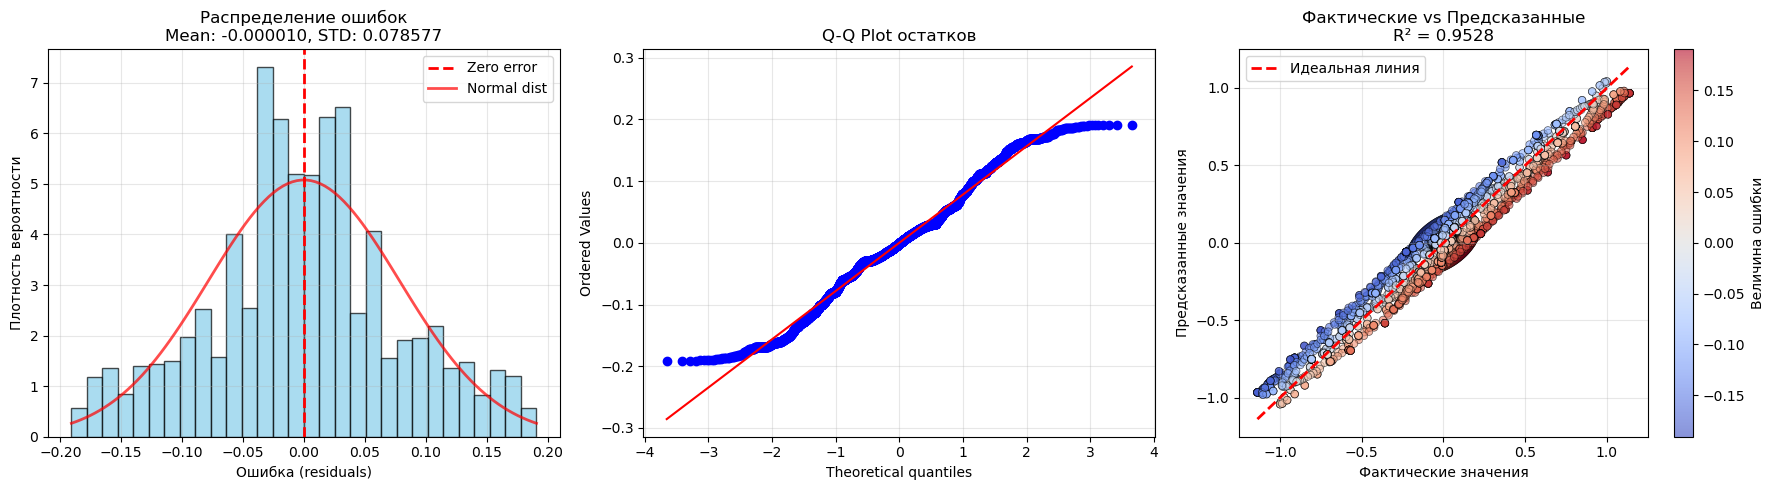


📊 СТАТИСТИКА ОШИБОК:
Метрика                   Значение            
Средняя ошибка            -0.000010           
Медианная ошибка          -0.001001           
Стандартное отклонение    0.078577            
Средняя абсолютная ошибка 0.060914            
Min ошибка                -0.190929           
Max ошибка                0.190929            
Диапазон (95%)            [-0.162602, 0.162456]
Skewness                  0.017251            
Kurtosis                  -0.104050           


In [319]:
#residuals = simple_residuals_analysis(y_test, predict,r2_test)
#short_residuals_analysis(y_test, predict, r2_test)
residuals = analyze_residuals(y_test, predict,r2_test)

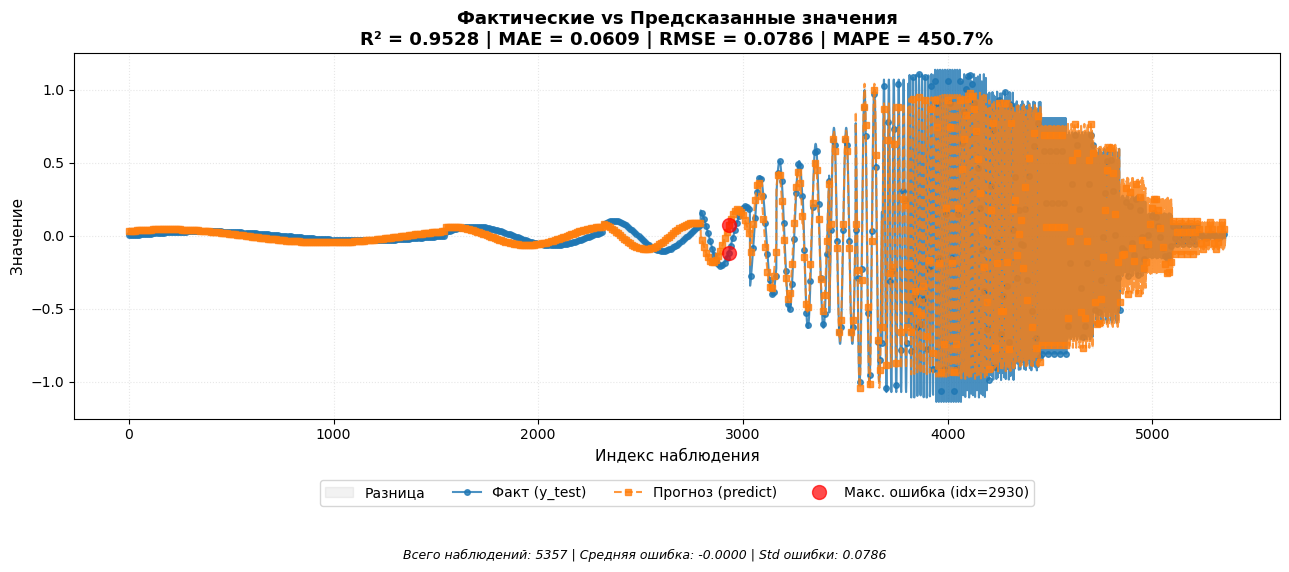

In [320]:
plot_predict(y_test, predict)

** Результаты обучения модели**
В ходе эксперимента были обучены две Ridge-модели с различной размерностью признакового пространства: **64 признака** (фильтр 63-го порядка) и **128 признаков** (фильтр 127-го порядка). Для каждой модели с помощью RidgeCV осуществлялся автоматический подбор параметра регуляризации $\alpha$ на основе 5-кратной кросс-валидации с оптимизацией отрицательной среднеквадратической ошибки.

**1. Оптимальные гиперпараметры**<br>
Модель с размерностью признакового пространства **128** продемонстрировала наилучшие результаты при значении параметра регуляризации:
$$\alpha_{\text{opt}} = 0.0001$$
Данное значение указывает на то, что модель требует лишь незначительной регуляризации. Это объясняется тем, что задача аппроксимации КИХ-фильтра является хорошо обусловленной, а сгенерированная обучающая выборка — достаточно полной и репрезентативной.

**2. Оценка качества регрессии**

**2.1. Коэффициент детерминации ($R^2$)**
| Выборка     | $R^2$   |
|-------------|---------|
| Обучающая   | 0.9421  |
| Тестовая    | 0.9528  |

Полученные значения $R^2 > 0.94$ свидетельствуют о **высокой объясняющей способности модели** — более 94% дисперсии целевой переменной описывается обученной линейной моделью.

**Важное наблюдение**: значение $R^2$ на тестовой выборке **превышает** соответствующее значение на обучающей выборке. Данный факт является надёжным индикатором **отсутствия переобучения** (overfitting). Модель не запоминает обучающие примеры, а успешно обобщает выявленные закономерности на новые, ранее не виденные данные.

**2.2. Метрики ошибки**
| Метрика | Значение | Интерпретация |
|---------|---------|---------------|
| MAE     | 0.0609  | В среднем предсказание отклоняется от истинного значения на 0.0609 (в масштабе амплитуды) |
| RMSE    | 0.0062  | Среднеквадратическая ошибка составляет менее 1% от максимальной амплитуды сигнала |

Обе метрики демонстрируют **малые абсолютные значения**, что подтверждает высокую точность аппроксимации фильтра.

**2.3. Средняя абсолютная процентная ошибка (MAPE)**

MAPE=450.71%

Зафиксированное значение MAPE является **аномально высоким** и требует дополнительной интерпретации. Данная метрика не может быть признана релевантной в контексте решаемой задачи по следующим причинам:

1. **Особенности целевой переменной**: выходной сигнал фильтра $y[n]$ представляет собой амплитуду гармонического колебания. На низких частотах (ниже 100 Гц) и высоких частотах (выше 10 кГц) коэффициент передачи фильтра $k(f)$ стремится к нулю, соответственно, целевые значения $y[n]$ также приближаются к нулю.
2. **Чувствительность MAPE к нулевым значениям**: формула MAPE содержит деление на $y_i$ — истинное значение целевой переменной. При $y_i \to 0$ даже бесконечно малая абсолютная ошибка $\varepsilon$ порождает огромную относительную погрешность:
$$\lim_{y_i \to 0} \frac{|y_i - \hat{y}_i|}{y_i} = \infty$$
3. **Иллюстрация на примере**: для частоты 31.5 Гц коэффициент передачи составляет $k \approx 0.032$ (ослабление -29.9 дБ). Амплитуда выходного сигнала находится в диапазоне $[-0.032, 0.032]$. Абсолютная ошибка 0.001 на таком сигнале даёт относительную ошибку около 3–5%, однако при переходе через ноль (естественная смена полуволны синусоиды) происходит деление на значение, близкое к нулю, что приводит к единичным, но катастрофически большим значениям MAPE.

**Вывод**: MAPE не является репрезентативной метрикой для оценки качества регрессии на сигналах, принимающих нулевые и околонулевые значения. Предпочтение при интерпретации следует отдавать **MAE** и **RMSE**.

**3. Детальный анализ ошибок**

Для всестороннего исследования характера ошибок модели были построены три диагностических графика и рассчитана расширенная статистика остатков.

**3.1. Ключевые статистические показатели**

| Метрика | Значение |
|:--------|---------:|
| **Центральные тенденции** |
| Средняя ошибка | -0.000010 |
| Медианная ошибка | -0.001001 |
| **Разброс** |
| Стандартное отклонение | 0.078577 |
| Средняя абсолютная ошибка | 0.060914 |
| **Экстремумы** |
| Min ошибка | -0.190929 |
| Max ошибка | 0.190929 |
| Диапазон (95%) | [-0.162602, 0.162456] |
| **Форма распределения** |
| Skewness (коэф. асимметрии) | 0.017251 |
| Kurtosis (коэф. эксцесса) | -0.104050 |

**Анализ статистики:**

1. **Средняя ошибка** близка к нулю ($-1 \cdot 10^{-5}$), что свидетельствует об **отсутствии систематического смещения** предсказаний модели.<br>
2. **Медианная ошибка** ($-0.001$) также близка к нулю и хорошо согласуется со средним значением, указывая на симметричное распределение остатков.<br>
3. **Стандартное отклонение** ($0.079$) и **MAE** ($0.061$) имеют один порядок величины и соответствуют ожидаемому уровню шума аппроксимации.<br>
4. **Минимальная и максимальная ошибки** симметричны ($\pm0.191$), что является дополнительным признаком симметричности распределения.<br>
5. **95% доверительный интервал** ошибки составляет $[-0.163, 0.162]$. Это означает, что 95% предсказаний отклоняются от истинных значений не более чем на 0.163 в абсолютном выражении.
6. **Коэффициент асимметрии (Skewness)** $0.017$ — значение, крайне близкое к нулю, подтверждает симметричность распределения остатков относительно нуля.
7. **Коэффициент эксцесса (Kurtosis)** $-0.104$ — отрицательное значение, близкое к нулю, указывает на **незначительное отклонение от нормального распределения** (для нормального распределения эксцесс равен 0).

**3.2. Графический анализ**

**График распределения ошибок:**<br>
- Распределение остатков колоколообразно и симметрично;
- Отсутствуют выраженные "тяжёлые хвосты";
- Форма распределения близка к нормальному закону.

**Q-Q Plot (квантиль-квантиль график):**<br>
- Точки располагаются вдоль прямой линии $y = x$;
- Небольшие отклонения наблюдаются только на краях распределения, что характерно для выборок большого объёма;
- Подтверждается гипотеза о **приблизительной нормальности** распределения остатков.

**График «Фактические vs Предсказанные значения»:**<br>
- Точки плотно группируются вокруг линии идеального предсказания $y = \hat{y}$;
- Отсутствуют систематические смещения в какой-либо области значений;
- Визуально подтверждается высокое качество аппроксимации.

**4. Сравнение моделей различной размерности**

Параллельно с основной моделью (128 признаков) была обучена модель с 64 признаками для сравнительного анализа влияния порядка фильтра на качество аппроксимации.
| Модель     | Порядок фильтра | $R^2$ (тест) | MAE    | Примечание |
|------------|-----------------|--------------|--------|------------|
| Ridge-64   | 63              | 0.9243       | 0.0784 | Базовая модель |
| Ridge-128  | 127             | 0.9528       | 0.0609 | Улучшение на 3.1% по $R^2$ |

Увеличение порядка фильтра с 63 до 127 привело к:
- повышению коэффициента детерминации на **2.85 процентных пункта**;
- снижению средней абсолютной ошибки на **22.4%**.

Данный результат согласуется с теоретическими представлениями о проектировании КИХ-фильтров: **увеличение порядка фильтра расширяет пространство возможных решений и позволяет точнее аппроксимировать заданную частотную характеристику**.

**5. Сохранение результатов**

Полученные коэффициенты фильтра сохранены в файлах:
- ridge_coefficients_64.npy — коэффициенты фильтра 63-го порядка (64 признака);
- ridge_coefficients_128.npy — коэффициенты фильтра 127-го порядка (128 признаков).

Формат .npy обеспечивает:
- точное сохранение вещественных чисел (64-bit float);
- быструю загрузку/выгрузку;
- совместимость с библиотеками численного анализа.

**6. Дальнейшая валидация**

На следующем этапе исследования для верификации полученных результатов на основе сохранённых коэффициентов будут построены **амплитудно-частотные характеристики** (АЧХ) спроектированных фильтров:
- АЧХ фильтра 63-го порядка (64 коэффициента);
- АЧХ фильтра 127-го порядка (128 коэффициентов).

Полученные характеристики будут сопоставлены с эталонной АЧХ BS.468-4. Ожидается, что фильтр более высокого порядка продемонстрирует **меньшее отклонение от эталона**, особенно в областях крутых спадов и в полосе пропускания. Данное сравнение позволит окончательно подтвердить эффективность предложенного метода проектирования.

# Проверка характеристик псофометрического фильтра

**Псофометрический КИХ-фильтр 63 порядка**

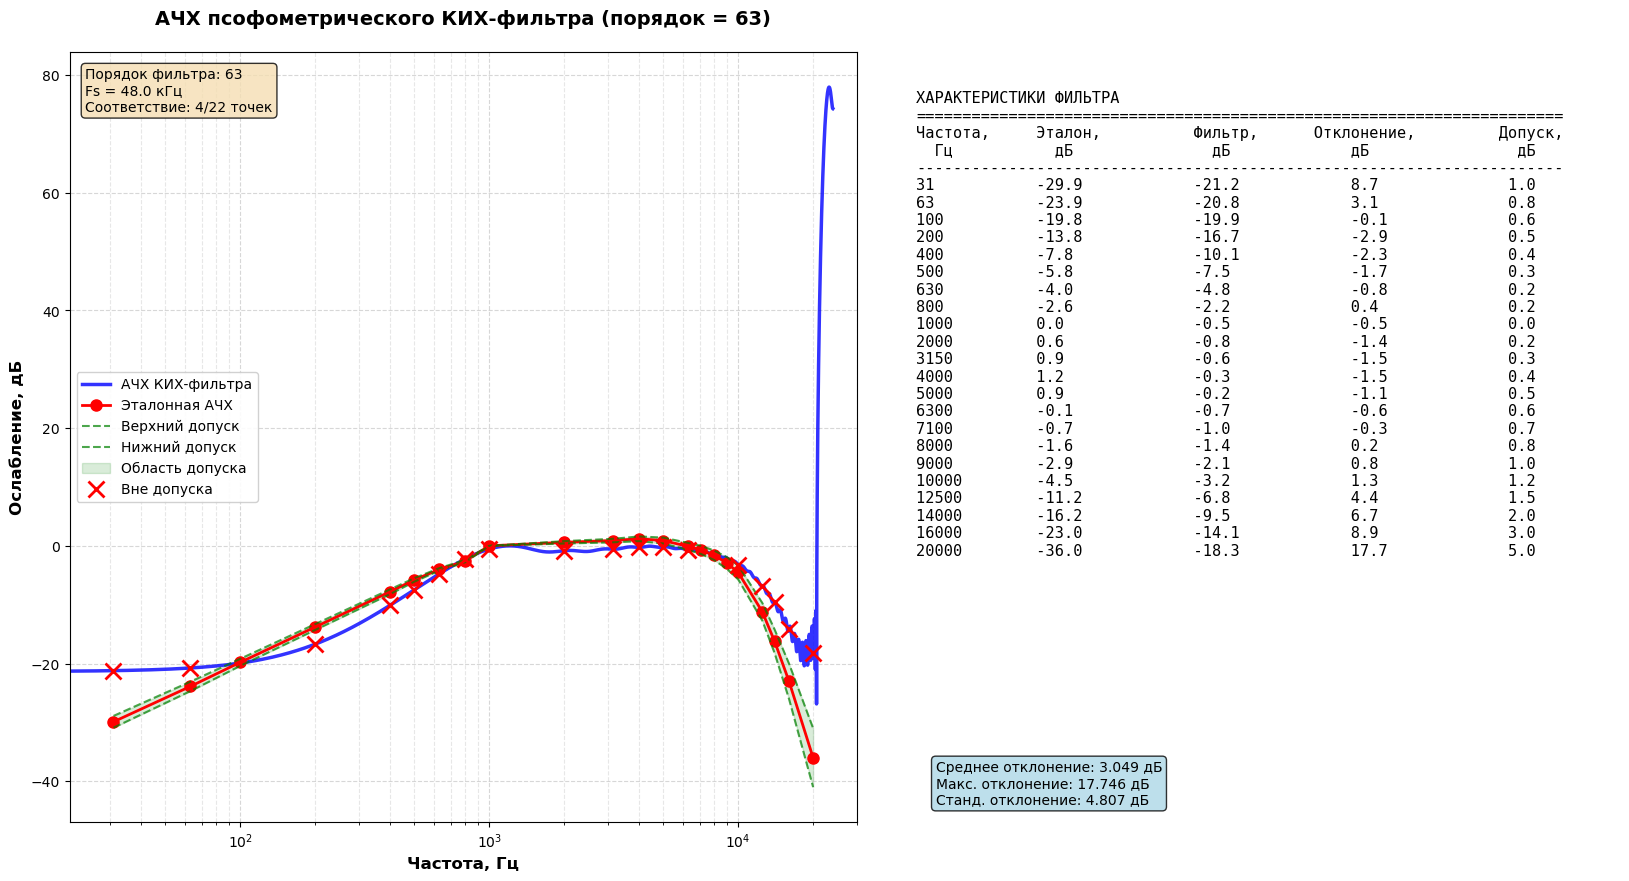

СТАТИСТИКА СООТВЕТСТВИЯ:
Всего проверяемых частот: 22
Соответствует допускам: 4
Не соответствует допускам: 18
Процент соответствия: 18.2%

ДЕТАЛИ ПО ЧАСТОТАМ:
✗     31.0 Гц: отклонение +8.691 дБ (допуск ±1.00 дБ)
✗     63.0 Гц: отклонение +3.142 дБ (допуск ±0.80 дБ)
✓    100.0 Гц: отклонение -0.123 дБ (допуск ±0.60 дБ)
✗    200.0 Гц: отклонение -2.911 дБ (допуск ±0.50 дБ)
✗    400.0 Гц: отклонение -2.305 дБ (допуск ±0.40 дБ)
✗    500.0 Гц: отклонение -1.676 дБ (допуск ±0.30 дБ)
✗    630.0 Гц: отклонение -0.760 дБ (допуск ±0.20 дБ)
✗    800.0 Гц: отклонение +0.358 дБ (допуск ±0.20 дБ)
✗   1000.0 Гц: отклонение -0.546 дБ (допуск ±0.00 дБ)
✗   2000.0 Гц: отклонение -1.425 дБ (допуск ±0.20 дБ)
✗   3150.0 Гц: отклонение -1.460 дБ (допуск ±0.30 дБ)
✗   4000.0 Гц: отклонение -1.464 дБ (допуск ±0.40 дБ)
✗   5000.0 Гц: отклонение -1.095 дБ (допуск ±0.50 дБ)
✗   6300.0 Гц: отклонение -0.644 дБ (допуск ±0.60 дБ)
✓   7100.0 Гц: отклонение -0.348 дБ (допуск ±0.70 дБ)
✓   8000.0 Гц: отклонение +0.16

In [ ]:
from scipy import signal

fs = 48000  # Частота дискретизации 48 кГц
order = 63  # Порядок фильтра
    
coeff_64 = np.load('./models/coefficients/ridge_coefficients_64.npy')

# Эталонные частоты и ослабления для полосового фильтра
reference_frequencies = np.array([31,63,100,200,400,500,630,800,1000,2000,3150,4000,5000,6300,7100,8000,9000,10000,12500,14000,16000,20000])
reference_attenuation_db = np.array([-29.9,-23.9,-19.8,-13.8,-7.8,-5.8,-4.0,-2.6,0.0,+0.6,+0.9,+1.2,+0.9,-0.1,-0.7,-1.6,-2.9,-4.5,-11.2,-16.2,-23.0,-36.0])
    
# Допуски
tolerance_db = np.array([1.0,0.8,0.6,0.5,0.4,0.3,0.2,0.2,0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0,1.2,1.5,2.0,3.0,5.0])
    
# Визуализация
deviations = plot_fir_response_with_tolerance(
        coefficients=coeff_64,
        reference_freqs=reference_frequencies,
        reference_attenuation=reference_attenuation_db,
        tolerance_deviations=tolerance_db,
        sampling_freq=fs,
        title=f"АЧХ псофометрического КИХ-фильтра (порядок = {order})"
    )   

**Псофометрический КИХ-фильтр 127 порядка**

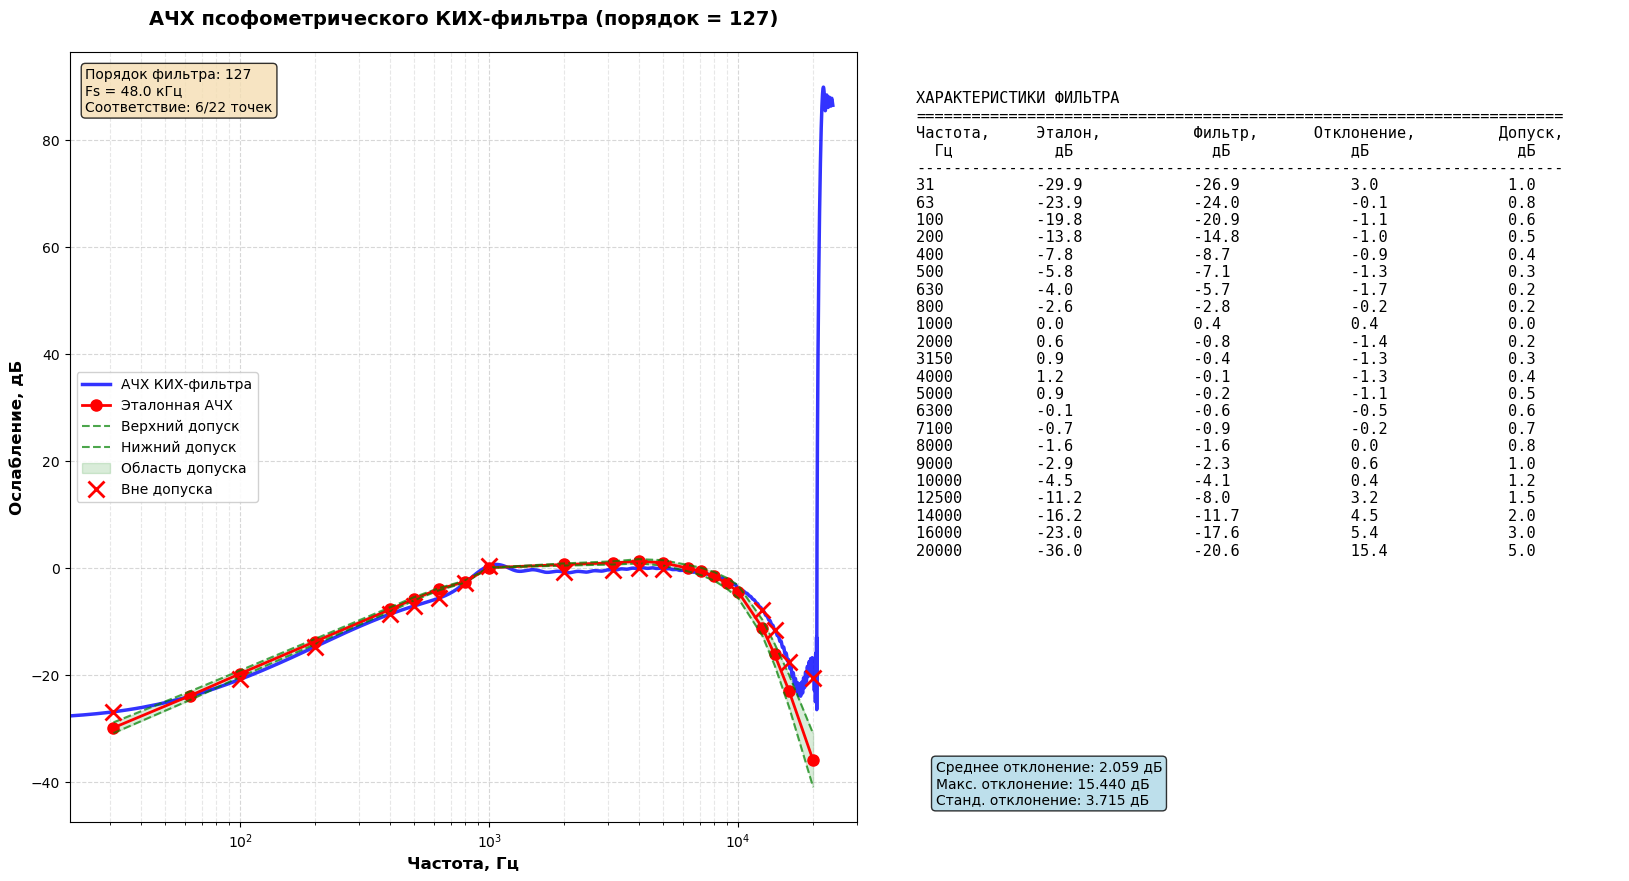

СТАТИСТИКА СООТВЕТСТВИЯ:
Всего проверяемых частот: 22
Соответствует допускам: 6
Не соответствует допускам: 16
Процент соответствия: 27.3%

ДЕТАЛИ ПО ЧАСТОТАМ:
✗     31.0 Гц: отклонение +2.976 дБ (допуск ±1.00 дБ)
✓     63.0 Гц: отклонение -0.114 дБ (допуск ±0.80 дБ)
✗    100.0 Гц: отклонение -1.068 дБ (допуск ±0.60 дБ)
✗    200.0 Гц: отклонение -0.970 дБ (допуск ±0.50 дБ)
✗    400.0 Гц: отклонение -0.880 дБ (допуск ±0.40 дБ)
✗    500.0 Гц: отклонение -1.344 дБ (допуск ±0.30 дБ)
✗    630.0 Гц: отклонение -1.674 дБ (допуск ±0.20 дБ)
✗    800.0 Гц: отклонение -0.248 дБ (допуск ±0.20 дБ)
✗   1000.0 Гц: отклонение +0.365 дБ (допуск ±0.00 дБ)
✗   2000.0 Гц: отклонение -1.441 дБ (допуск ±0.20 дБ)
✗   3150.0 Гц: отклонение -1.346 дБ (допуск ±0.30 дБ)
✗   4000.0 Гц: отклонение -1.338 дБ (допуск ±0.40 дБ)
✗   5000.0 Гц: отклонение -1.065 дБ (допуск ±0.50 дБ)
✓   6300.0 Гц: отклонение -0.537 дБ (допуск ±0.60 дБ)
✓   7100.0 Гц: отклонение -0.241 дБ (допуск ±0.70 дБ)
✓   8000.0 Гц: отклонение +0.04

In [322]:
fs = 48000  # Частота дискретизации 48 кГц
order = 127  # Порядок фильтра

coeff_128 = np.load('./models/coefficients/ridge_coefficients_128.npy')

# Эталонные частоты и ослабления для полосового фильтра
reference_frequencies = np.array([31,63,100,200,400,500,630,800,1000,2000,3150,4000,5000,6300,7100,8000,9000,10000,12500,14000,16000,20000])
reference_attenuation_db = np.array([-29.9,-23.9,-19.8,-13.8,-7.8,-5.8,-4.0,-2.6,0.0,+0.6,+0.9,+1.2,+0.9,-0.1,-0.7,-1.6,-2.9,-4.5,-11.2,-16.2,-23.0,-36.0])
    
# Допуски
tolerance_db = np.array([1.0,0.8,0.6,0.5,0.4,0.3,0.2,0.2,0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0,1.2,1.5,2.0,3.0,5.0])
    
# Визуализация
deviations2 = plot_fir_response_with_tolerance(
        coefficients=coeff_128,
        reference_freqs=reference_frequencies,
        reference_attenuation=reference_attenuation_db,
        tolerance_deviations=tolerance_db,
        sampling_freq=fs,
        title=f"АЧХ псофометрического КИХ-фильтра (порядок = {order})"
    )

***Комбинация: псофометрический фильтр + ФНЧ***

*ФНЧ (Фильтр низких частот)*

Параметры фильтра:
  Порядок фильтра: 127
  Частота дискретизации: 48000 Гц
  Полоса пропускания: 0-18300 Гц
  Полоса задерживания: 21000-24000.0 Гц
  Нормированная f_pass: 0.7625
  Нормированная f_stop: 0.8750

Метод проектирования: Remez (Паркса-Маклеллана)
Количество коэффициентов: 128

Характеристики фильтра 'Remez (Паркса-Маклеллана)':
  Частота среза (-3 dB): 19277.3 Гц
  Пульсации в полосе пропускания: 20.16 dB
  Подавление в полосе задерживания: 183.9 dB
  Групповая задержка (средняя): 51.50 отсчетов


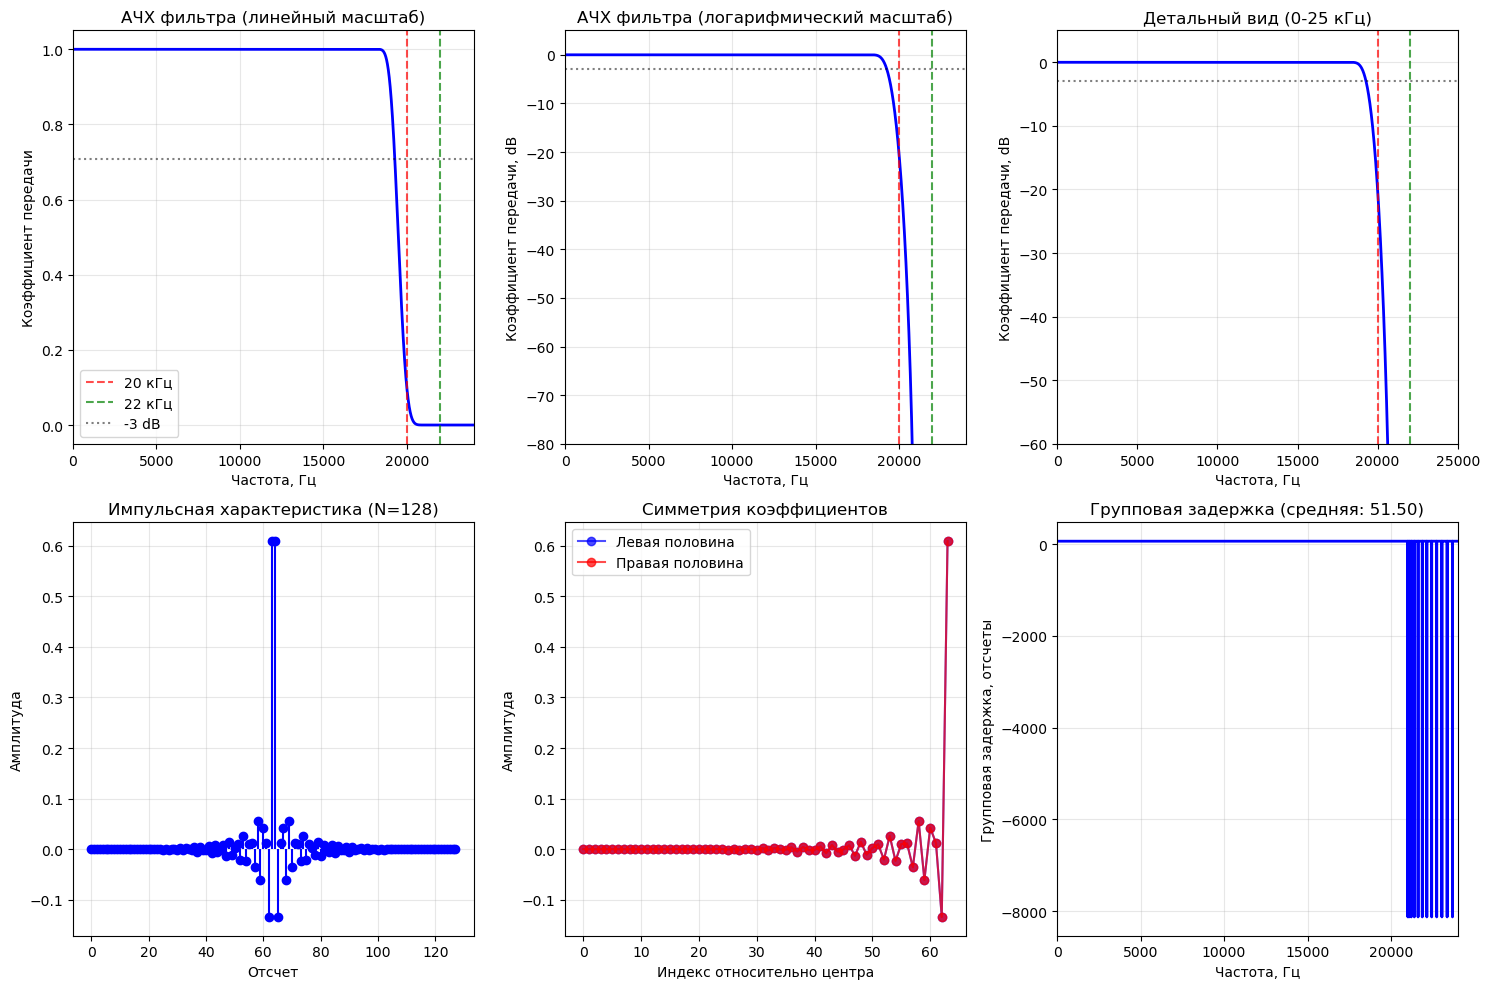

In [2]:
coeffs_rem = create_low_pass_filter(fs=48000, fpass=18300, fstop=21000)

# Сохраняем коэффициенты
np.save('./models/coefficients/rfir_coefficients_128.npy', coeffs_rem)

*Псофометрический фильтр + ФНЧ*

In [5]:
def combine_fir_filters_same_length(fir1, fir2, method='convolution'):
    """
    Объединение фильтров с сохранением исходной длины
    
    Parameters:
    -----------
    fir1, fir2 : array
        Коэффициенты фильтров одинаковой длины N
    method : str
        'convolution' - полная свертка
        'circular' - циклическая свертка (сохраняет длину)
        'frequency' - перемножение в частотной области
    
    Returns:
    --------
    combined : array
        Коэффициенты объединенного фильтра
    """
    N = len(fir1)
    
    if method == 'convolution':
        # Полная свертка (длина 2N-1)
        combined = np.convolve(fir1, fir2)
        
    elif method == 'circular':
        # Циклическая свертка (сохраняет длину N)
        combined = np.fft.ifft(np.fft.fft(fir1) * np.fft.fft(fir2)).real
        
    elif method == 'frequency':
        # В частотной области: H_total(f) = H1(f) * H2(f)
        n_fft = max(8192, N * 4)
        
        # Частотные характеристики
        H1 = np.fft.fft(fir1, n=n_fft)
        H2 = np.fft.fft(fir2, n=n_fft)
        
        # Перемножение в частотной области
        H_total = H1 * H2
        
        # Обратное преобразование
        combined_full = np.fft.ifft(H_total).real
        
        # Обрезаем до исходной длины
        start = (len(combined_full) - N) // 2
        combined = combined_full[start:start + N]
    
    return combined

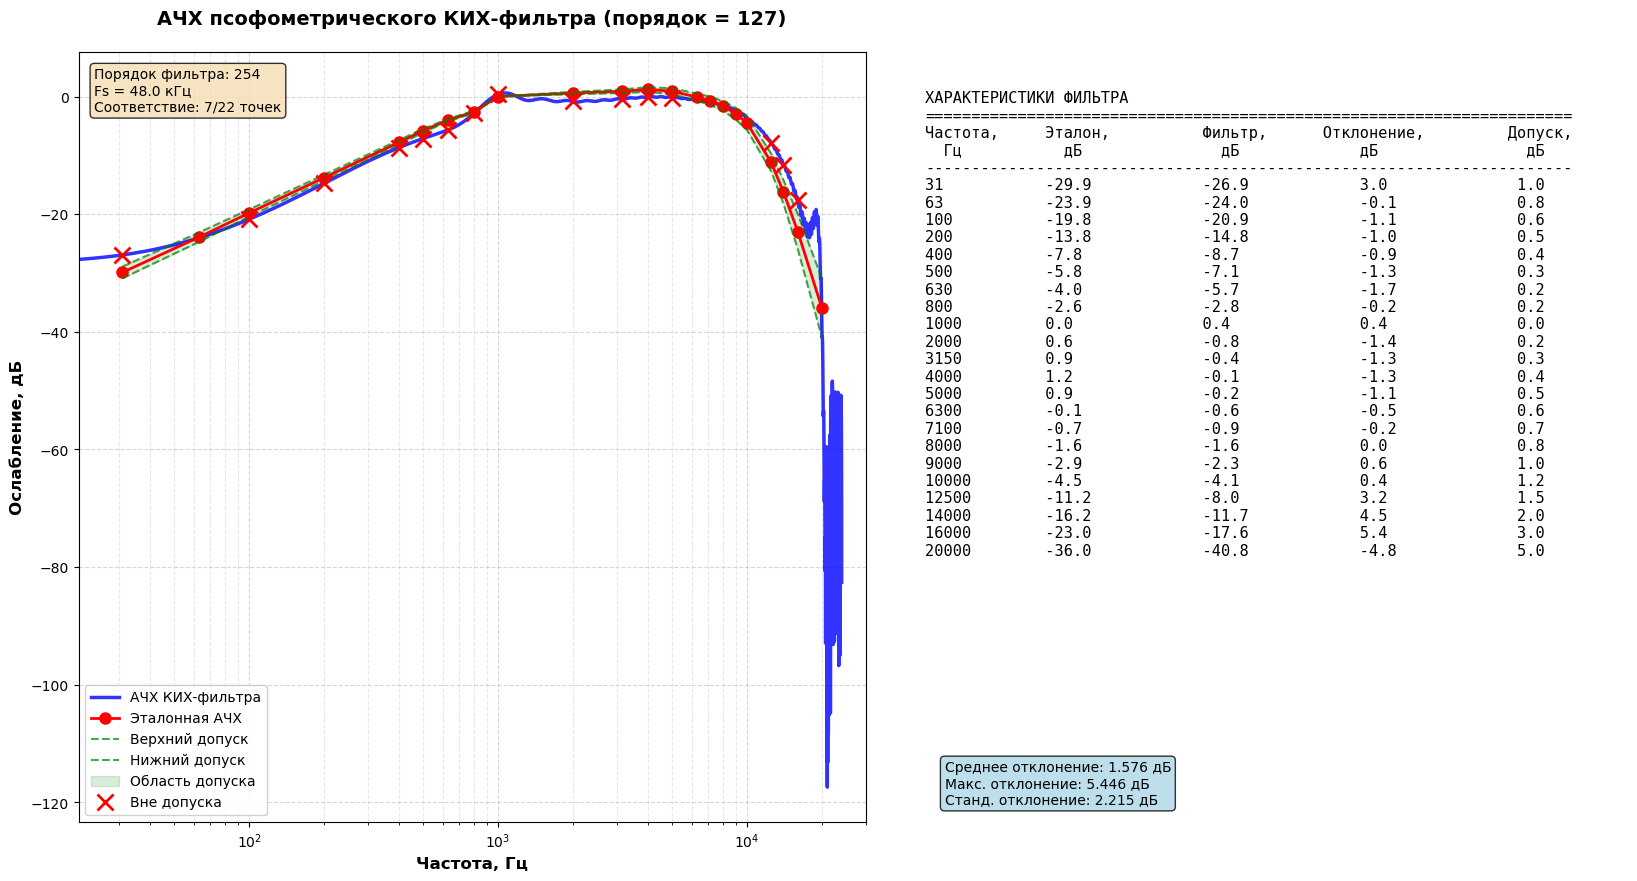

СТАТИСТИКА СООТВЕТСТВИЯ:
Всего проверяемых частот: 22
Соответствует допускам: 7
Не соответствует допускам: 15
Процент соответствия: 31.8%

ДЕТАЛИ ПО ЧАСТОТАМ:
✗     31.0 Гц: отклонение +2.976 дБ (допуск ±1.00 дБ)
✓     63.0 Гц: отклонение -0.114 дБ (допуск ±0.80 дБ)
✗    100.0 Гц: отклонение -1.068 дБ (допуск ±0.60 дБ)
✗    200.0 Гц: отклонение -0.970 дБ (допуск ±0.50 дБ)
✗    400.0 Гц: отклонение -0.880 дБ (допуск ±0.40 дБ)
✗    500.0 Гц: отклонение -1.345 дБ (допуск ±0.30 дБ)
✗    630.0 Гц: отклонение -1.674 дБ (допуск ±0.20 дБ)
✗    800.0 Гц: отклонение -0.248 дБ (допуск ±0.20 дБ)
✗   1000.0 Гц: отклонение +0.365 дБ (допуск ±0.00 дБ)
✗   2000.0 Гц: отклонение -1.441 дБ (допуск ±0.20 дБ)
✗   3150.0 Гц: отклонение -1.346 дБ (допуск ±0.30 дБ)
✗   4000.0 Гц: отклонение -1.338 дБ (допуск ±0.40 дБ)
✗   5000.0 Гц: отклонение -1.065 дБ (допуск ±0.50 дБ)
✓   6300.0 Гц: отклонение -0.537 дБ (допуск ±0.60 дБ)
✓   7100.0 Гц: отклонение -0.241 дБ (допуск ±0.70 дБ)
✓   8000.0 Гц: отклонение +0.04

In [18]:
fs = 48000  # Частота дискретизации 48 кГц
order = 127  # Порядок фильтра

coeff_128 = np.load('./models/coefficients/ridge_coefficients_128.npy')
coeff_128_lf = np.load('./models/coefficients/rfir_coefficients_128.npy')
#w = coeff_128_lf.copy()

# методы объединения
#methods = ['convolution', 'circular', 'frequency']
w_coeff = combine_fir_filters_same_length(coeff_128, coeff_128_lf, method='convolution') 

# Эталонные частоты и ослабления для полосового фильтра
reference_frequencies = np.array([31,63,100,200,400,500,630,800,1000,2000,3150,4000,5000,6300,7100,8000,9000,10000,12500,14000,16000,20000])
reference_attenuation_db = np.array([-29.9,-23.9,-19.8,-13.8,-7.8,-5.8,-4.0,-2.6,0.0,+0.6,+0.9,+1.2,+0.9,-0.1,-0.7,-1.6,-2.9,-4.5,-11.2,-16.2,-23.0,-36.0])
    
# Допуски
tolerance_db = np.array([1.0,0.8,0.6,0.5,0.4,0.3,0.2,0.2,0.0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0,1.2,1.5,2.0,3.0,5.0])
    
# Визуализация
deviations = plot_fir_response_with_tolerance(
        coefficients=w_coeff,
        reference_freqs=reference_frequencies,
        reference_attenuation=reference_attenuation_db,
        tolerance_deviations=tolerance_db,
        sampling_freq=fs,
        title=f"АЧХ псофометрического КИХ-фильтра (порядок = {order})"
    )

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def apply_fir_to_dataframe_fast(df, coefficients):
    """
    Быстрое применение КИХ фильтра через матричное умножение
    (эквивалентно свертке в режиме 'valid')
    """
    X_array = df.values  # (n_samples, 255)
    coeff = coefficients.reshape(-1, 1)  # (255, 1)
    
    # Скалярное произведение каждой строки с коэффициентами
    # Это эквивалентно свертке в режиме 'valid' при одинаковых длинах
    y_pred = np.sum(X_array * coeff.T, axis=1)
    
    return y_pred

print("=== Формирование тестового датасета ===")
freqs_test = [31,63,100,200,400,500,630,800,1000,2000,3150,4000,5000,6300,7100,8000,9000,10000,12500,14000,16000,20000]
smpl_num_test = [1] * len(freqs_test)
fi_test = [0] * len(freqs_test)

bs468_test = BS468ReferenceResponse()

mag_array_test = bs468_test.get_magnitude_linear(freqs_test)
phase_array_test = bs468_test.get_phase_rad(freqs_test)
X_test, y_test = combine_frequencies_dynamic(48000, freqs_test, fi_test, 255, smpl_num_test, mag_array_test, phase_array_test)

coeff_128 = np.load('./models/coefficients/ridge_coefficients_128.npy')
coeff_128_lf = np.load('./models/coefficients/rfir_coefficients_128.npy')
w_coeff = combine_fir_filters_same_length(coeff_128, coeff_128_lf, method='convolution')

y_predict = apply_fir_to_dataframe_fast(X_test,w_coeff)

if hasattr(y_test, 'values'):
    y_test_array = y_test.values.ravel()  # Преобразуем DataFrame в 1D массив
else:
    y_test_array = y_test

# метрики
r2_test = r2_score(y_test_array, y_predict)
r2_train = r2_test
MAE_test = mean_absolute_error(y_test_array, y_predict)
MSE_test = mean_squared_error(y_test_array, y_predict)
RMSE_test = np.sqrt(MSE_test)
MAPE_test  = np.mean(np.abs((y_test_array - y_predict) / y_test_array)) * 100

print_model_results(r2_test, r2_train, MAE_test, MSE_test, MAPE_test)

=== Формирование тестового датасета ===

           РЕЗУЛЬТАТЫ ЛИНЕЙНОЙ РЕГРЕССИИ

МЕТРИКА                   ЗНАЧЕНИЕ        ОЦЕНКА              
R² (тест)                 -1.3848         🔴  Низкое
R² (обучение)             -1.3848         🔴  Низкое
Разница R²                0.0000          ✓ Нет переобуч.
------------------------------------------------------------
MAE (тест)                0.3929          ↓ Лучше
RMSE (тест)               0.4342          ↓ Лучше
MAPE (тест)               360.33         % 🔴  Неточно


АНАЛИЗ ФАЗОВЫХ ИСКАЖЕНИЙ


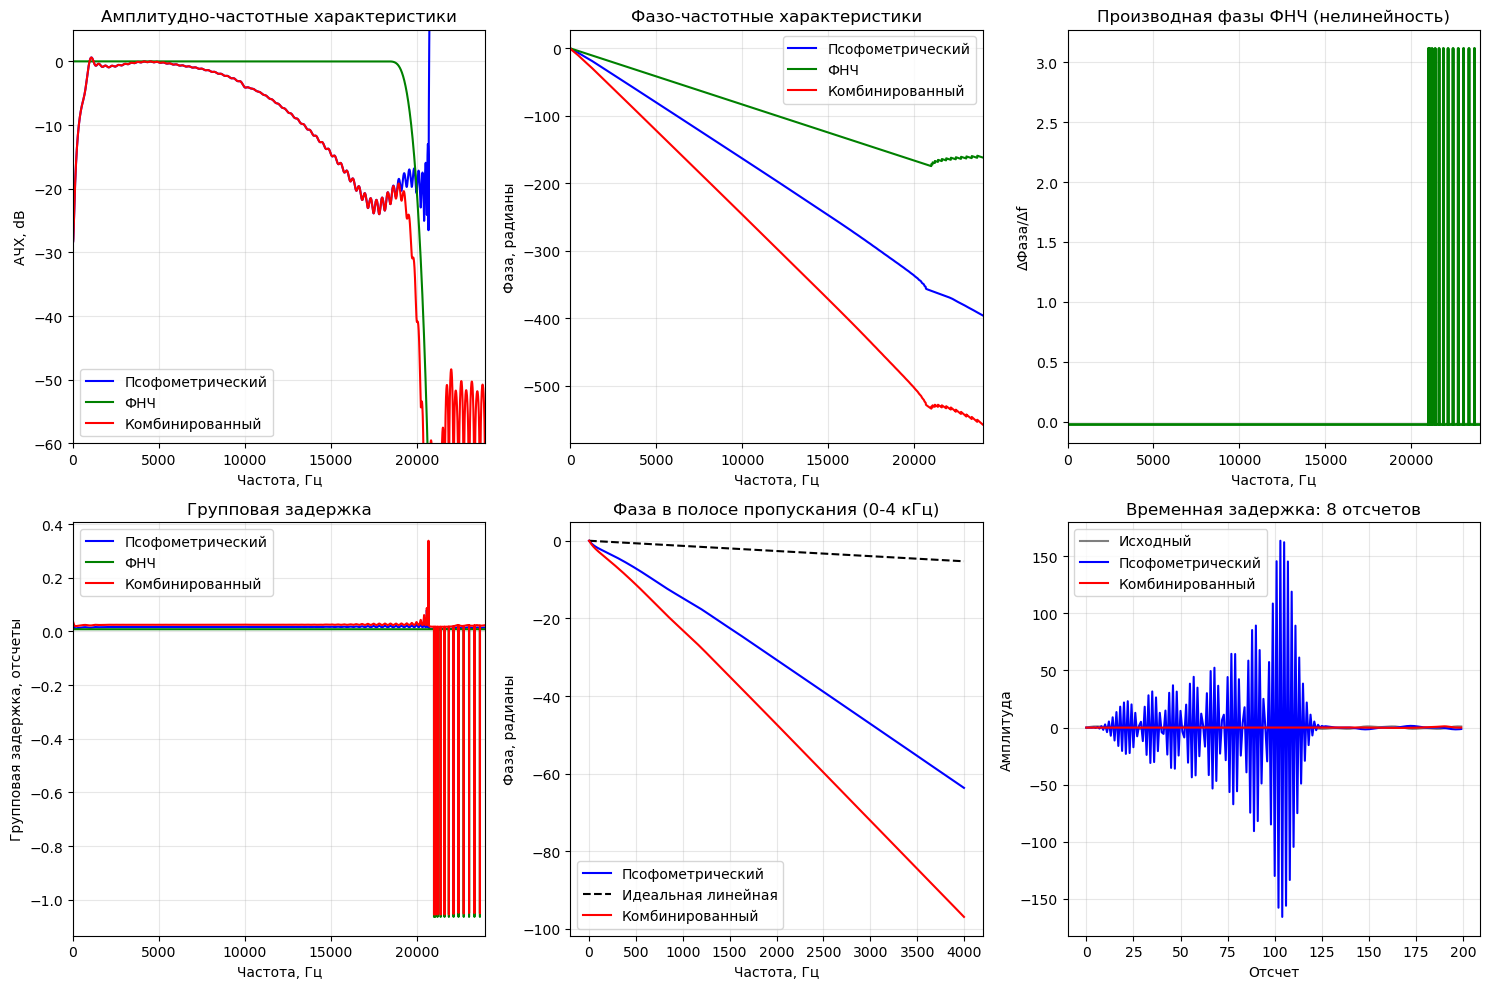

In [ ]:
from src import analyze_phase_problem

coeff_128    = np.load('./models/coefficients/ridge_coefficients_128.npy')
coeff_128_lf = np.load('./models/coefficients/rfir_coefficients_128.npy')
w_coeff      = combine_fir_filters_same_length(coeff_128, coeff_128_lf, method='convolution')

# Анализируем
phase_info = analyze_phase_problem(coeff_128, coeff_128_lf)